In [ ]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

In [ ]:
from binsense.config import DATA_DIR
print(DATA_DIR)

import binsense.dataprep.downloader as d
d.download()

import binsense.dataprep.metadata as m
bin_df, item_df = m.load()
print(bin_df.shape, item_df.shape)


In [ ]:
from binsense.owlv2 import hugg_loader as l
from binsense.owlv2 import Owlv2Config
from binsense.owlv2 import Owlv2ForObjectDetection, Owlv2ImageProcessor
import numpy as np

processor = Owlv2ImageProcessor(**l.load_owlv2processor_config())
model = Owlv2ForObjectDetection(Owlv2Config(**l.load_owlv2model_config()))
model.load_state_dict(l.load_owlv2model_statedict())
model.eval()
print()

In [ ]:
import torch
import PIL

from binsense.config import BIN_S3_DOWNLOAD_IMAGES_DIR as imgdir
from scipy.special import expit as sigmoid

def get_topk_bboxes(image_path, topk):
    sample_image = PIL.Image.open(image_path)
    image_pixels = processor.preprocess(sample_image)['pixel_values']

    with torch.no_grad():
        image_embeds, _ = model.image_embedder(image_pixels)
        bbox_logits  = model.objectness_predictor(image_embeds)
        bboxes = model.box_predictor(image_embeds)
        # print('embeds=', image_embeds.shape, ', bbox_logits=', bbox_logits.shape, ', bboxes=',  bboxes.shape)
        
    padded_item_image = PIL.Image.fromarray(processor.unnormalize_pixels(image_pixels)[0])
    target_sizes = torch.Tensor([padded_item_image.size[::-1]])
    boxes = processor.post_process_bounding_boxes(boxes=bboxes, target_sizes=target_sizes)
    boxes = np.array(boxes[0].detach())
    objectnesses = np.array(bbox_logits[0].detach())

    # Plot top k objects on Query Item Image
    topk_boxscores = []
    
    objectnesses = sigmoid(objectnesses)
    topk_objectness = sorted([(i, score) for i, score in enumerate(objectnesses)], key=lambda x: x[1], reverse=True)[:topk]
    # objectness_threshold = np.partition(objectnesses, -topk)[-topk]

    for i, score in topk_objectness:
        # if objectness < objectness_threshold:
        #     continue
        topk_boxscores.append((boxes[i], score))
        
    return padded_item_image, topk_boxscores

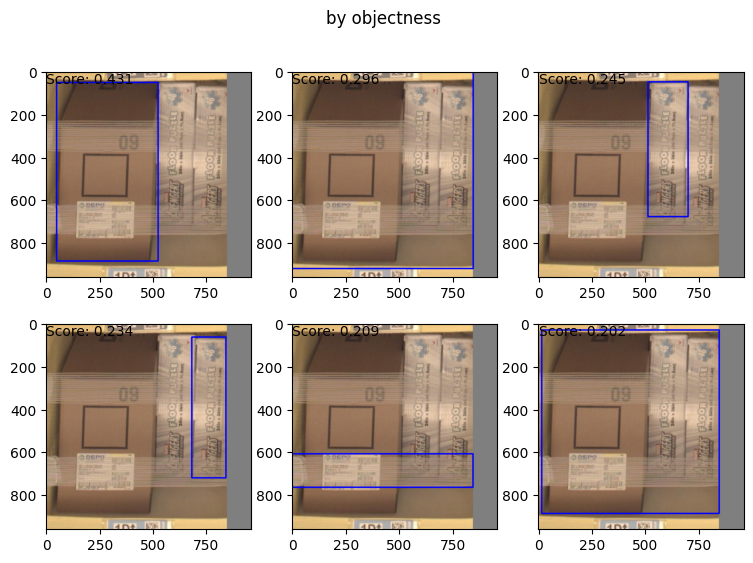

In [ ]:
from binsense.plot_utils import show_bbox_ingrid

img, box_scores = get_topk_bboxes('../docs/sample_bin.jpg', 6)
show_bbox_ingrid(np.array(img), box_scores, grid=(2, 3), title="by objectness")

In [18]:
from binsense.lightning.config import Config as TrainConfig

AttributeError: 'Config' object has no attribute 'keys'

In [15]:
from binsense.lightning.metrics import QueryAccuracy
from binsense import torch_utils as tutls
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt

exists_acc = QueryAccuracy(criteria="exists")
exists_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
exists_acc(
    preds=tutls.to_int_tensor([1, 2]), 
    targets=tutls.to_int_tensor([0, 2]))
val = exists_acc.compute().item()
print(val, 4/7)
assert round(4/7, 1) == round(val, 1)

matches_acc = QueryAccuracy(criteria="matches")
matches_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
val = matches_acc.compute().item()
print(val, 2/5)
assert round(2/5, 1) == round(val, 1)

meets_acc = QueryAccuracy(criteria="meets")
meets_acc(
    preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10]), 
    targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5]))
val = meets_acc.compute().item()
print(val, 3/6)
assert round(3/6, 1) == round(val, 1)

conf_matrix = MulticlassConfusionMatrix(num_classes=6)
preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10])
targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5])
pred_classes = preds.clone()
pred_classes[pred_classes > 4] = 5
tgt_classes = targets.clone()
tgt_classes[tgt_classes > 4] = 5
conf_matrix(pred_classes, tgt_classes)

f, ax = plt.subplots(1, 1, figsize = (10,7))
f, _ = conf_matrix.plot(ax=ax)
plt.close(f)
f


0.5714285969734192 0.5714285714285714
0.4000000059604645 0.4
0.5 0.5


matplotlib.figure.Figure

In [1]:

from binsense.lightning.config import Config as TrainConfig
from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.dataset import LitInImageQuerierDM
from binsense.lightning.model import LitInImageQuerier
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.cli.owlv2.train import train, _get_baseline_model
from binsense import torch_utils as tutls
import logging, PIL, torch
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

def _get_transform_fn(embed_ds):
    processor = Owlv2ImageProcessor()
    def transform(inputs):
        inputs['image'] = processor.preprocess(inputs['image'])['pixel_values'][0]
        inputs['query'] = embed_ds.get(inputs['query']).reshape((1, -1))
        return inputs
    return transform

cfg = TrainConfig()
embed_ds = SafeTensorEmbeddingDatastore(cfg.embed_store_dirpath, read_only=True)
data_module = LitInImageQuerierDM(
    data_dir=cfg.data_dirpath,
    csv_filepath=cfg.data_csv_filepath, 
    batch_size=2, 
    num_workers=0, transform=_get_transform_fn(embed_ds))
data_module.setup(stage=None)
lmodel = LitInImageQuerier(_get_baseline_model())

def check_for_empty(dl, desc):
    for batch in tqdm(dl, desc=desc):
        if len(batch[0]) == 0 or len(batch[1]) == 0:
            print("empty batch")

train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()

image_path = '/Users/n0c09jf/code/github/binsense/_data/bin/filtered_dataset/train/images/02278.jpg'
inputs_0 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00K5NELR0"})
inputs_1 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00PLRGOKC"})
inputs = { 
        "image": torch.stack([inputs_0["image"],  inputs_1["image"]]), 
        "query": torch.stack([inputs_0["query"], inputs_1["query"]]),
        "idx": torch.stack([tutls.to_int_tensor(198), tutls.to_int_tensor(199)])
}

gt_labels = [tutls.empty_int_tensor(), tutls.to_int_tensor([0, 0])]
gt_counts = [tutls.to_int_tensor(0), tutls.to_int_tensor(2)]
gt_boxes = [
    tutls.empty_float_tensor(), 
    tutls.to_float_tensor([[0.4919262230396271, 0.5147766323024056, 0.32922131147540984,0.8304810996563573], 
                           [0.7953483462333679, 0.5082130584192439, 0.3489344262295082, 0.7902061855670103]])
]
targets = {
    "count": gt_counts,
    "labels": gt_labels,
    "boxes": gt_boxes
}
print(lmodel.training_step((inputs, targets), 0))
# outputs = lmodel.model(inputs)
# lmodel.loss(outputs, targets)
# print(outputs["pred_boxes"].shape, outputs["pred_logits"].shape, targets)
# preds = lmodel.select_preds(outputs)
# print(lmodel._compute_metrics(preds, targets, 'train', inputs["idx"]))
# [p.shape for p in preds["pred_boxes"]]

# check_for_empty(train_dl, "train_dl")
# check_for_empty(val_dl, "val_dl")

# for i, batch in tqdm(enumerate(train_dl), desc="train_dl"):
#     if len(batch[1]["boxes"]) != 2:
#         print(batch[0]["idx"])
        
#     if batch[1]["boxes"][1].shape[0] == 2 \
#         and batch[1]["boxes"][1][0].shape[0] > 1 \
#         and batch[1]["boxes"][1][0][0].item() == 0.4919262230396271:
#         print(batch[1])
#         outputs = lmodel.model(batch[0])
#         if len(outputs["pred_boxes"]) == 0:
#             print(batch[0]["idx"])
#         else:
#             preds = lmodel.select_preds(outputs)
#             if len(preds["pred_boxes"]) == 0:
#                 print(batch[0]["idx"])


2024-04-12 06:46:17,123 INFO : 
                train/val/test split, 
                len=1007/95/140, 
                ratio=0.8/0.1/0.1
            
2024-04-12 06:46:18,475 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.


tensor(12.9016, grad_fn=<AddBackward0>)


/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [1]:
from binsense.cli.owlv2.train import train
from binsense.lightning.config import Config as TrainConfig
from lightning.pytorch.loggers import TensorBoardLogger
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')
cfg = TrainConfig()
tlogger = TensorBoardLogger(cfg.tb_logs_dir, version='test')
train(
    min_epochs=1, 
    batch_size=2, 
    fast_dev_run=1,
    logger=tlogger,
    profiler='simple',
    use_focal_loss=True,
    eos_coef=0.0,
    accelerator='mps'
)

kwargs:  {'min_epochs': 1, 'fast_dev_run': 1, 'logger': <lightning.pytorch.loggers.tensorboard.TensorBoardLogger object at 0x3315b3110>, 'profiler': 'simple', 'use_focal_loss': True, 'eos_coef': 0.0, 'accelerator': 'mps'}
Config:  Config(data_dirpath='/Users/n0c09jf/code/github/binsense/data/bin', data_csv_filepath='/Users/n0c09jf/code/github/binsense/data/bin/inimage_queries.csv', embed_store_dirpath='/Users/n0c09jf/code/github/binsense/data/bin/embed_store', chkpt_dirpath='/Users/n0c09jf/code/github/binsense/data/bin/chkpts', results_csv_filepath='/Users/n0c09jf/code/github/binsense/data/bin/test_results.csv', results_topk_bboxes=15, experiment_version=None, learning_rate=1e-05, lr_decay_rate=0.95, min_epochs=1, max_epochs=100, batch_size=2, num_workers=0, reg_loss_coef=1, giou_loss_coef=1, label_loss_coef=1, eos_coef=0.0, use_focal_loss=True, focal_loss_alpha=0.3, focal_loss_gamma=2.0, match_cost_label=1, match_cost_bbox=1, match_cost_giou=1, iou_threshold=0.98, nms_threshold=1, sco

2024-05-12 01:04:32,082 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
2024-05-12 01:04:33,585 INFO : 
                train/val/test split, 
                len=134/7/20, 
                ratio=0.8/0.0/0.1
            

   | Name              | Type                      | Params
-----------------------------------------------------------------
0  | model             | OwlV2InImageQuerier       | 91.2 M
1  | loss              | DETRMultiBoxLoss          | 0     
2  | train_exists_acc  | QueryAccuracy             | 0     
3  | val_exists_acc    | QueryAccuracy             | 0     
4  | test_exists_acc   | QueryAccuracy             | 0     
5  | train_conf_matrix | MulticlassConfusio

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                    

In [2]:
from binsense.cli.owlv2.train import test
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

test(
    batch_size=8, 
    # ckpt_fname='run_v4_best_loss.ckpt',
    experiment_version='test_baseline',
    # fast_dev_run=1,
    # score_threshold=0.95,
    accelerator='mps'
)

Config:  Config(data_dirpath='/Users/n0c09jf/code/github/binsense/data/bin', data_csv_filepath='/Users/n0c09jf/code/github/binsense/data/bin/inimage_queries.csv', embed_store_dirpath='/Users/n0c09jf/code/github/binsense/data/bin/embed_store', chkpt_dirpath='/Users/n0c09jf/code/github/binsense/data/bin/chkpts', results_csv_filepath='/Users/n0c09jf/code/github/binsense/data/bin/test_results.csv', results_topk_bboxes=15, experiment_version=None, learning_rate=1e-05, lr_decay_rate=0.95, min_epochs=10, max_epochs=100, batch_size=8, num_workers=0, reg_loss_coef=1, giou_loss_coef=1, label_loss_coef=1, eos_coef=1.0, use_focal_loss=True, focal_loss_alpha=0.3, focal_loss_gamma=2.0, match_cost_label=1, match_cost_bbox=1, match_cost_giou=1, iou_threshold=0.98, nms_threshold=1, score_threshold=0.95, use_no_object_class=False)
kwargs:  {'accelerator': 'mps'}


2024-05-12 14:09:14,889 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-05-12 14:09:16,122 INFO : 
                train/val/test split, 
                len=133/6/18, 
                ratio=0.8/0.0/0.1
            
/Users/n0c09jf/miniconda3/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

2024-05-12 14:09:16,270 INFO : backing up /Users/n0c09jf/code/github/binsense/data/bin/testresults_test_baseline.csv to /Users/n0c09jf/code/github/binsense/data/bin/testresults_test_baseline.csv.1.bkp


TypeError: cannot unpack non-iterable NoneType object

In [1]:
from binsense.dataset_util import COCODatasetBuilder, YoloDatasetBuilder
from binsense import config as cfg
from binsense.dataset_util import ImageData, DataTag

from typing import List

import numpy as np

import os

ds = COCODatasetBuilder.build_from_file("/Users/n0c09jf/Downloads/annotations/instances_val2017.json")
images_data = ds.get_images()
r_idxs = np.random.randint(0, len(images_data), 300)
filtered_images_data = [images_data[i] for i in r_idxs]

cat_ids = []
cats = {}
for cat in ds.data['categories']:
    cat_ids.append(cat["id"])
    cats[cat["id"]] = cat["name"]
cat_ids = sorted(cat_ids)
cat_names = [cats[i] for i in cat_ids]
print(cat_ids)
print(cat_names)

yolobuild = YoloDatasetBuilder()
yolobuild.add_categories(cat_names)

def add_to_yolo(images_data: List[ImageData], tag: DataTag):
    for img_data in images_data:
        img_id = yolobuild.add_image(
            img_name=img_data.name,
            tag=tag,
            img_path=os.path.join(f"/Users/n0c09jf/Downloads/val2017/{img_data.name}")
        )
        for bbox in ds.get_bboxes(img_data.name):
            category_id = yolobuild.add_category(bbox.label)
            yolobuild.add_bbox(img_id, category_id, bbox.to_array())

train_len, val_len, test_len = (210, 30, 60)
add_to_yolo(filtered_images_data[0:train_len], DataTag.TRAIN)
add_to_yolo(filtered_images_data[train_len:val_len], DataTag.VALID)
add_to_yolo(filtered_images_data[train_len+val_len:], DataTag.TEST)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse

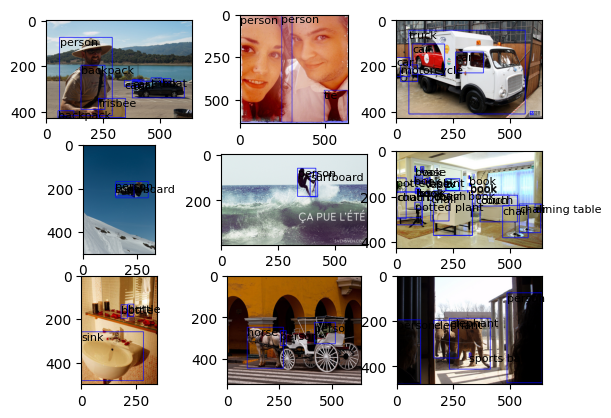

In [12]:
from matplotlib import pyplot as plt
from binsense.plot_utils import plot_bboxes
from binsense.img_utils import convert_cxy_xy_and_scale

import PIL


yolo_ds = yolobuild.build()
def show_image(img_data, ax):
    img_pil = PIL.Image.open(img_data.path)
    boxes_data = yolo_ds.get_bboxes(img_data.name)
    bboxes_cxy = np.array([b.to_array() for b in boxes_data])
    bboxes_xy = convert_cxy_xy_and_scale(bboxes_cxy, (img_pil.width, img_pil.height))
    labels = [b.label for b in boxes_data]
    plot_bboxes(np.array(img_pil), bboxes_xy, labels, ax=ax)

f, axs = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        show_image(yolo_ds.get_images()[np.random.randint(0, 200)], ax=axs[i][j])



In [3]:
from binsense.dataprep.config import coco_cfg

cfg = coco_cfg()
yolobuild.build().to_file(cfg.filtered_dataset_path, format='yolov8')

In [29]:
from binsense.dataprep.embedding_util import BBoxDatasetEmbedder
from binsense.dataprep.config import coco_cfg, DataPrepConfig
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')
cfg = coco_cfg()
print(list(filter(lambda x: x[0] != '_', [n for n in cfg.__dir__()])))
print(cfg.__getattribute__('robo_project'))
cfg.__setattr__('robo_project', 'somethingelse')
print(cfg.__getattribute__('robo_project'))

['root_dir', 'dataset_download_path', 'filtered_dataset_path', 'inimage_queries_csv', 'embed_store_dirpath', 'raw_data_root_dir', 'data_split_images_dir', 'data_split_labels_dir', 'raw_data_img_extn', 'data_split_filepath', 'label_chkpt_filepath', 'bbox_chkpt_filepath', 'robo_upload_dir', 'batch_size', 'dataset_class', 'rfmeta_file_path', 'inimage_queries_pos_neg_ratio', 'roboql_dataset_url', 'robo_workspace', 'robo_project', 'robo_ann_group', 'robo_dataset_version', 'robo_workspace_id', 'robo_project_id', 'robo_meta_check_tags']
binsense_bbox_mini
somethingelse


In [1]:
from binsense.dataprep.metadata import BinMetadataLoader
from binsense.config import DATA_DIR
import logging, os

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

print('process', os.getpid())
bin_df, item_df = BinMetadataLoader().load(
    source_dir=os.path.join(DATA_DIR, 'amzbin'), 
    max_workers=15)
print(bin_df.shape, item_df.shape)

2024-04-26 03:10:36,000 INFO : reading csv files


process 59594
(536433, 7) (1415740, 12)


In [7]:
import torch

class BackPropDemo(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.L1 = torch.nn.Linear(1, 2, bias=False)
        self.L2 = torch.nn.Linear(2, 4, bias=False)
        self.H1 = torch.nn.Linear(4, 1, bias=False)
        self.H2 = torch.nn.Linear(4, 1, bias=False)
        self.fn = torch.nn.functional.sigmoid
    
    def forward(self, X):
        h = self.L1(X)
        h = self.L2(h)
        h1 = self.H1(h)
        h2 = self.H2(h)
        return self.fn(h1), self.fn(h2)

def freeze_layer(layer):
    for p in layer.parameters():
        p.requires_grad = False

model = BackPropDemo()
freeze_layer(model.L1)
freeze_layer(model.L2)
optim = torch.optim.SGD(model.parameters(), lr=0.1)
lossfn = torch.nn.functional.binary_cross_entropy

print("*********************************************")
print("********* demo training H1  head ************")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
# y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
print("loss computation followed by gradient update")
y1_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)

print("*********************************************")
print("********* demo training H2  heads ***********")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
# y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)

print("*********************************************")
print("********* demo training H1 & H2  heads ******")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
total_loss = y1_loss + y2_loss
total_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)


*********************************************
********* demo training H1  head ************
*********************************************
H1 --> Parameter containing:
tensor([[-0.0411,  0.0506,  0.3532, -0.0599]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)
y1 --> tensor([0.5056], grad_fn=<SigmoidBackward0>) y2 --> tensor([0.4806], grad_fn=<SigmoidBackward0>)
loss computation followed by gradient update
H1 --> Parameter containing:
tensor([[-0.0472,  0.0538,  0.3549, -0.0619]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)
*********************************************
********* demo training H2  heads ***********
*********************************************
H1 --> Parameter containing:
tensor([[-0.0472,  0.0538,  0.3549, -0.0619]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)

In [14]:
import pandas as pd
from binsense.config import DATA_DIR

df = pd.read_csv(DATA_DIR+'/bin/products.csv')
mask  = df['item_name'].str.contains('health', case=False, regex=True)
df = df[mask]
df.iloc[0:10]


,item_id,item_name
9,0071833102,"LANGE Q&A Radiography Examination, Tenth Editi..."
12,0073380806,Health Education: Elementary and Middle School...
80,0553385097,The New Mediterranean Diet Cookbook: A Delicio...
134,1284036790,Legal And Ethical Issues For Health Professionals
448,B000BHDLQM,"Mabis Dmi Healthcare Rubber Water Bottle, Red,..."
522,B000FGWBH4,Designs for Health Ferrochel Iron Chelate Caps...
686,B000WFPJIG,(Pack of 12) Wellness Complete Health Grain Fr...
722,B00124YDMY,"Spry Xylitol Gum, Spearmint, 600 Pieces - Grea..."
749,B0014291SA,American Health Original Papaya Enzyme Chewabl...
762,B0015S4ZJI,Health Enterprises 360 Therapy Wrist Brace


duplicate image name(100833.jpg) with path(/Users/n0c09jf/code/github/binsense/data/bin/robo_download/train/images/100833_jpg.rf.7bde539ee3d2574998a14b8be9e18cb4.jpg)
duplicate image name(100832.jpg) with path(/Users/n0c09jf/code/github/binsense/data/bin/robo_download/train/images/100832_jpg.rf.b6cdccae6734c034eafc45d82befbc3f.jpg)


/Users/n0c09jf/code/github/binsense/data/bin/robo_download/train/images/02754_jpg.rf.e831da764853b7d5cc2402b38a1d5c5c.jpg


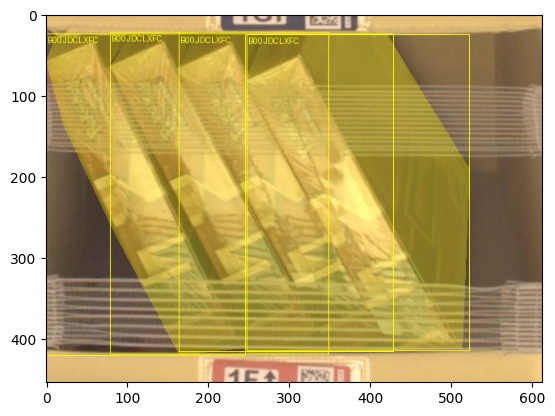

In [25]:
from binsense.dataprep.roboflow_util import RoboflowDatasetReader
from binsense.dataset_util import DataTag
from binsense.dataprep.config import DataPrepConfig
from binsense.img_utils import create_polygon_mask, annotate_image

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.ops import box_convert
import torchvision.transforms.v2  as transforms

from matplotlib import pyplot as plt

import numpy as np
import PIL, torch, random

cfg = DataPrepConfig()
ds = RoboflowDatasetReader(
        dataset_dirpath=cfg.dataset_download_path,
        cfg=cfg).read()

imgs_data = ds.get_images(DataTag.TRAIN)
random.shuffle(imgs_data)
for img_data in imgs_data:
    image = PIL.Image.open(img_data.path).convert('RGB')
    bboxes_data = ds.get_bboxes(img_data.name)
    mask_imgs = []
    labels = []
    bboxes = []
    for bbox_data in bboxes_data:
        coords = bbox_data.segmentation[0].copy()
        coords[:,0] *= image.width
        coords[:,1] *= image.height
        mask_imgs.append(create_polygon_mask(image.size, coords))
        
        labels.append(bbox_data.label)

        bbox_cxy = bbox_data.to_array().copy()
        bbox_cxy[[0,2]] *= image.width
        bbox_cxy[[1,3]] *= image.height
        bboxes.append(bbox_cxy)
    
    # Convert mask images to tensors
    masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

    # Annotate the sample image with segmentation masks
    annotated_tensor = draw_segmentation_masks(
        image=transforms.PILToTensor()(image), 
        masks=masks, 
        alpha=0.3,
        colors=[(255,255,0)]*len(mask_imgs)
    )

    # Annotate the sample image with labels and bounding boxes
    annotated_tensor = draw_bounding_boxes(
        image=annotated_tensor, 
        boxes=box_convert(torch.Tensor(bboxes), 'cxcywh', 'xyxy'),
        labels=labels,
        colors=[(255,255,0)]*len(labels)
    )
    annotated_image = PIL.Image.fromarray(np.moveaxis(annotated_tensor.numpy(), 0, -1))
    print(img_data.path)
    # plt.imshow(annotated_image)

    labels = [bbox_data.label for bbox_data in ds.get_bboxes(img_data.name)]
    bboxes_cxy = np.array([ bbox_data.to_array() for bbox_data in ds.get_bboxes(img_data.name) ])
    seg_coords = [ bbox_data.segmentation[0] for bbox_data in ds.get_bboxes(img_data.name) ]
    plt.imshow(annotate_image(image, labels, bboxes_cxy, seg_coords))

    break
    

[6]


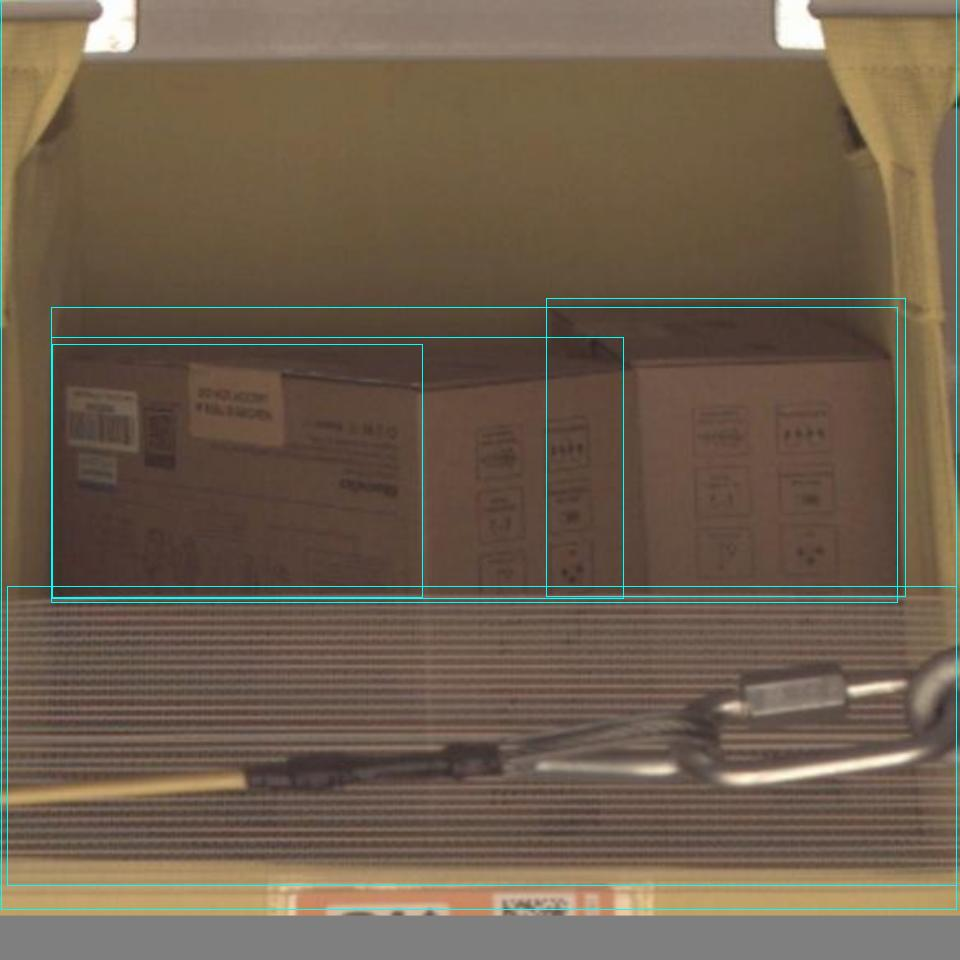

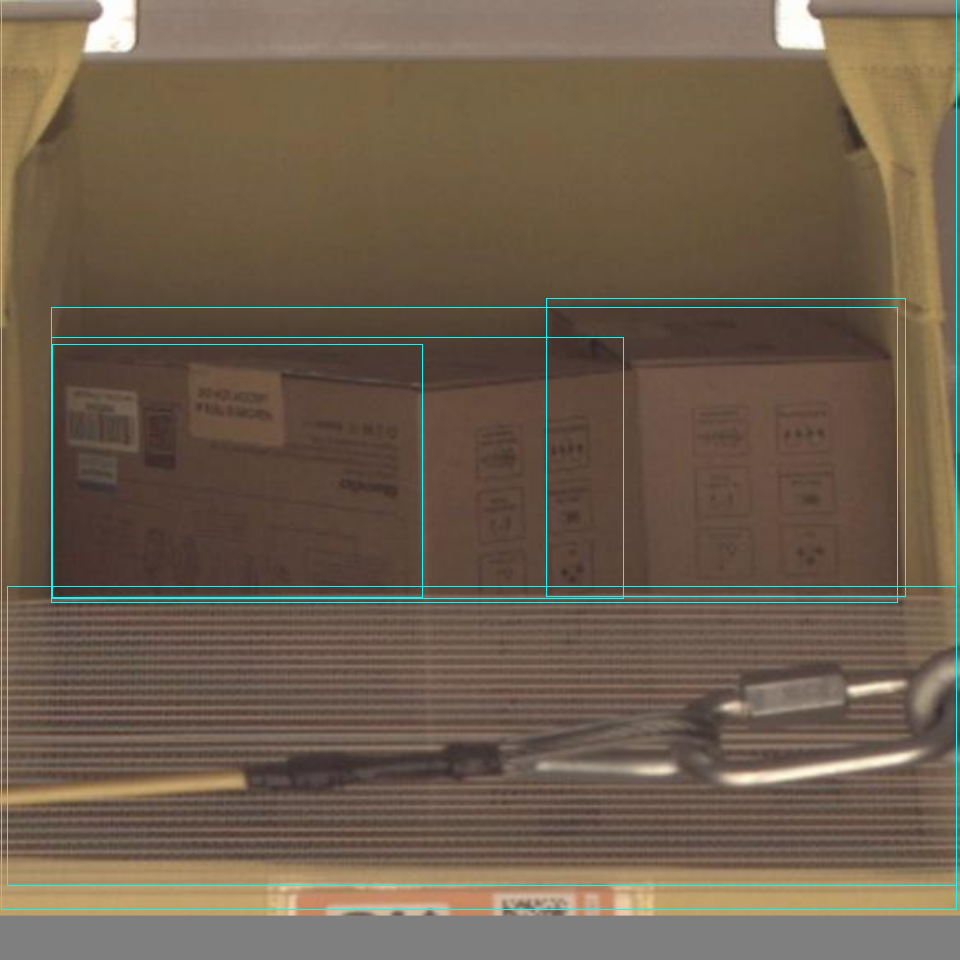

In [3]:
import base64, os, PIL, logging
from io import BytesIO

from binsense.model_api import ModelApi
from binsense.config import BIN_DATA_DIR
from binsense.model_api import ModelApi, OwlImageQuerier, OwlBinPreprocessor
from binsense.owlv2.config import Owlv2Config
from binsense.owlv2 import hugg_loader as hloader
from binsense.owlv2.model import Owlv2ForObjectDetection
from binsense.embed_datastore import EmbeddingDatastore, SafeTensorEmbeddingDatastore

def _get_owl_baseline_model() -> OwlImageQuerier:
    owl_model_cfg = Owlv2Config(**hloader.load_owlv2model_config())
    model = Owlv2ForObjectDetection(owl_model_cfg)
    model.load_state_dict(hloader.load_owlv2model_statedict())
    return OwlImageQuerier(model=model, threshold=0.95)

def build_owl_model() -> ModelApi:
    owl_model = _get_owl_baseline_model()
    preprocessor = OwlBinPreprocessor(owl_model.processor)
    embed_ds = SafeTensorEmbeddingDatastore(f'{BIN_DATA_DIR}/embed_store', read_only=True).to_read_only_store()
    return ModelApi(
        model=owl_model, 
        preprocessor=preprocessor,
        embed_ds=embed_ds,
        bin_images_dir=None)

base64_str = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAItAkgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDQ/tGY9ZnP/AjTTfSEg+c//fRrDxee1MJuunFcalE6eXyN/wC3Sf8APVvzpPtzf89T+dYP+lEU3Fz3Ip867hy+Rv8A24/89D+dH20n/lofzrDEVy38Qpwt7rHDij2i7hym2L0DPzn866Dwjrk0WsxW28vFKdpTPAPrXGWmm6heXMcEADSOcAGvUfCXgxtHkF5fSB7nGFVei1rB31JkklqdlQelLVedZ2BMbKK0k7GKR5N4u+XxWxPTy+OPesguDnmtDxOXPiiQOeVjFZZODXOjoY4sO1JvGaQk0Z4qgFLgUhYHFIScUHpQAFwaA4BpnNLSAeGGO9KDUYpfegCbNFRrxSrQBJigk4pmKTJoAeG9qbnPNIF70baAFLdhRyRzTDR2zQA/pSHPWmUhoEPJHpTSc03tR0pgPHSgUyjFAD8880uRUYpaAHg0fWmYpTQMdntRnNMxRQA6jNJ2pPpQA78aSkxSEUCF/Sj8abjmigY7IpfpTO3Sl5oEOzzS+lM6UoHFAx+RxijPpTRgc0UgH544pN3tSDmjFMB272o3cU360Y9KBDg3Yikz83Q0ho4HWgYY3XEAx1kHX617XoieXpyLnj09K8TXIuID/wBNB/OvbdIBOnx4PH0qoGVQ0K84+JN1cRXVqhBFvjIIHVq9HrN1rQ7XXLJra6GR1Vh1U1buyYtJ6nigveOTTTeLmr/iDwkuiah5C3Dyow3KxGD9KyP7MXP32rmdSKdmdCi3sTG9UDrQL1ar/wBmL/eNB0sf3z0pe1iHKyz9sBHFKLsetU200jkMenrUX2JgfvH86ftYhys0vta460fah/eqgtgzfxHp/ep39msf4z+dL2sQ5WXftQ/vUfahj71Um0xgPvn86rtZupPztR7WIcrNT7UPWis1bLf/ABtmij2kQ5WbrKFHBFVjktxirMh9qhUDPeuVGgLGcZyKb5SkjjNWABt6E0Kh9KLgJHGMfcqTGOKWNDin7MVNxnReCLQTa15pP+qTd/SvTK4jwLHHBDcTSOiliAMtXXNfWqfeuIh9WFelR92ByVXeRN5q79meacelZk1/FK4ENzEU/iKuMinXGsWFraGWS6jCKP72SatSvclqx5f4wAHjCdRnAjXrWMauapdNqes3OoEEeZgKD/dHSqpXNZG6I8Zozxin7aCoxQBGRxSdql28UCMUARYoxUuz3o2c0AR44pwAp+0YNKqjoaAGAZNOxinKqgnJqTYpA5oAhI44oxxU/lr0zSbE4yaAISKQntUp25xTMDOc0DGBcHk0YqXCHFPCx46igRVIpO+atbYx/FTGCZ4oAgxSYqYquRRtXg5oAhxR7VOQhppVcZoAjAox61MAoHNGEP1oAixRUny5pMCgBhBpMVIMd6UhaAIqMZqTKigbe9AEf1pCOKlwueKbgCgBlHJp+0etLtHWgCOjk07ilwPWgBmKXvTjjFKADxTAaBzR7U7A9aAB60gEopw20ZFADeopMgEU75c8Uhwe9ADcAHmlwD0o4pcigBjkq8RHUOP517hpBLabEWAyQOleIsquuM13mg+NobXT47a+Rt8YCh1H3hVRdjOaPQaK5dPHOksfvuB7rUq+NNIYg+eQD2KHitFOJnZmV4/st0dvdgdDtY4rg8H0GK7rxP4g0vVNJaCGfdIGDL8p/wA964nywT14NcGIa5tDqpfCRYPp3phAzVjyyTTWQ5zWNzQgKAjqRUJj54Jq4Q2OxqPbnHy/pQmFiui8jJNTKBjvTWXB+73qaPPFNsSGkLjvVZ0Ug9zV11O2otvHQ0JgVYxhsAUVOF/ejOMelFMCRwWbGaVV6dM1U3HLEHJx3pUaRVwG59aVgL6Ak44p5SqCysGU7uf51a83JBHTFSMsQLkGnSYQE+lJAjCHOefeqWp3RggIzlm4pLVjexB/a3luwVjjPY01tXLd8/jWPuwc96NxrsjOysYuKNb+1sdP5006pu61lbjRnPNV7Ri5TT/tIegpP7SHoKzs0nXFLnHyml/aI9KT+0fYVn9qMmj2gWND+0fQCj+0T6Cs/PNGaOcLGh/aJ9BR/aB9Kz84paOdhYvfbz6Uf2g3pVCnZo5wsXPt7elL/aD+hqln60Z9KXtAsXTqUnp+lIdQcnoap96CaPaMOUt/2g47Gg37+hqp1pPwo52HKW/t7+9H9oSehqpmjNHtGHKW/t8nfNB1Bx61V60wrk5o9ow5S59vfqc0f2i/vVNuRQKfOw5UXPt8mO9H9oSe9VO1H86OdhYtfb5Pel+3ye9VKKXOwsW/t8h9aPt8nvVTNHFHtGFi19uk96PtslVQaM4o52Fi19tf3o+2ye9Vc0Zp+0YWRa+2ye9H22Q1VpKOdhYt/bZOmaPtkmKq0dqXOwsWvtklH2ySqo96XNPnYWLP22T1o+2yetVKXNLnY7Fr7bJ60fbZPU1U7e9Jk0c7CyLn21/WkN7J71UzzSZp87FZFz7a/Sk+2v71UzSZoU2FkXTeyZoF89U80Uc7CyLgvnxS/bpPxqkDijPOaOdhYu/b5AcUf2i/I5qiWNJmjnYWRoJqTb1BBIzW9A2+MHvXHlsYxXQ6RcebCFLHIrGrrqVHQ0ypGaZJUjoD3PHvUEy7sHJH41z3NBrY6ZxTRx3qI7vMLf1pobZnk5qxEzgA8kUiHD4zVV8lSAT+NNDknknI6HNOwjRGGz81Nx1wc1C53IMce4pGkKkEelKwxTzIMcmio7SPzJz8xH40UNgMAyelTKgwP8KRFOQcCpgOBwKGwICACOO9WYFaRguKhlzx9e1X7KPYgY8k0pPQEtSd8Rx8dhXIajdG5vWAPyrxW3r18tpZNg4dhha4+2cvJuJ5rSjDS7Jk9S9SUo5FHetSQFHNFAFIBaO4opKYCnmkyRSiikMM0A80UtMAoozRSAKKKB1oEL9aO1HSigAoopaYCE0UUUgEpR0pO9FAC0hNLTWNCGBFLRRTEFJRijpQAZozzQTSCgBeM0tJRQADijg0DrSmkAmKWigUAJntQaXvTTTAWjNApTSATvS5pOho7UABPWjmkpTTATpRQaKAEyc0EUGj8aAE96KMUHrQAZoHakpaADpSZo/GjIoAKb9aDSEimAh6Vc0u58m5Ck4VuKpE8UwsUIbpihq6sB3ilSoIpHUEEVT0i7FzaA8Ejgirx+lcbVmarVFFtwY00gnPFSzrzmq4I55qkIayZPK1XbKNwMVbPJ4bt7VXlU9c8VSBk0bsVFK5IXpUEXXGaklPy5JGMUuoiWz4VnY80Vlalqa2On4VgJHGAKKr2blqhc1jVRQMc44qUAbeSPzpB1X5f1okICHj9akoiUB5wPStQN5UJJ4AFZ1opZy2O9UfEWqfZ4Ps8bfO/XnoKOXmdgvZGFrl+by8YBsovAqvbEA9OapDLN61ft1KjJFddlFWMupdU8ClpopfxqBi0v403NLRYAxz1paSjIIosAUvWkzS0WAKKKO1IApaSl70DCiiigBTijtSGl7UCDvS/hSUCmAelJQTRSADxQDRmkzQMdSHHeig0xBSUuaTrQAvajtSGikAEZNIOOMUtJmmAtHejrRQAtFJnFGaAFxRSUUALRSZ5ooAKXrSUZoAKO1FJzQAvpRSfSjNMApOPWjig0gDg0nejIooAKQjBooNABRSUUwCk70ZpKAFNNNBNJmgBDzUFxnZgVPUcn3acdxD/DmoPa6l5MhOx+Bmu87ZznNeVTyNBcxyKenNei6Herf6dHJn5gMN9azxEPtDhLoWpl3DFUW4JHGa0nyRgdKz5hsesImrBTjAI7YpJFG3knOe2aemWpXBCUxFUKFbvwaS4kCp9KlfucVRvJCQFzWkI3ZL0KNxBFdPulXce3tRT80V2LRWMzolB45qGdjtwDU6hdg4qnM6iQZPA5rz1ubMlkuFsrNpG6gcfWuKupZry5eVwck/lW5d3vnEj+BegrMDDceMV0U48upm3cihi8tcnrVgcEGmdXzTs1bETDGBS00dKXr9KgY7NL60ylBoAXPBpc0meaTPNADqOaSigB3ejNIDRmgBc0opvalzQAuaKTrRzRYBc0uaaTSmiwC5optHU0DFzRSGjrQAvekoPXA4pOpoEO7c0ZpBRQAEiikzRQApozzxSY9KKYC0mRRk0maQDhRzTQaXn8KYBmlpvajrSAdRTaM0DHE0ZpvelFAhSaM0nTtRQAUdO9HSkP60wFzRxSUUgDNB60naimAUUUlAC5pKQ9aQ0ALxSZxQTSUALmm5opOnamApNNpTSZ4pAIelJjHWlpp6U0Izb1QynHbpWj4U1Q2t15EjYjc/rTGs2mbgfKanttLhgIYn5gciqk042Yra3O9blQQOMVRuV74p+mXIubYLu+ZeDUtyhKk1w7M23RQjIBOTUzAFTyarDg1ZRsg8dqpoSIJeFPPGKyJmzKa17jAjPFYjHLk9s10UVqTIWikorpMzpRxH0FYGoXBaQxqfY1vMStsT7Vy0pJuHJ9a4aauzWQjJiM4quY8GrT8R4qFutbokaRjtxR0pSOBSdqAJB05ozTVPFLmgB2eKXNNo+lIB2aKQGkyaYDwRRTRR9KQDh0NLmmjrRQA/PakJpM0UALS803NBNIB2aD1BptLmmAueaM030pc0MAozx1pKSkgHGkpO9FMBwNGcU0cUZxQA7NJSE8UmfWgB9IaaDS5oAXNHekzSE0WC47vS/jTATRmmA7NA60hoBpWAWikooAWgUlITxQA7OaUmmZpaAHCgkU0Hijn8KAFoJppOaOTQgFpc9abnHXpRmgAzS5pp4oJoAKCaTNIaYC5pD60E0hoAWkJwOKM0maADNFITSZNAMWmnAoJ5pCeKBEkcjKeDVlZB7kmqQOCKsxtxQ0BoaZcyQ3i44Vjg5rpLonyCUODXIh9rhh25rpml82xVvVetc9RamkWZZnw+HGPerlvKG4BqkygnmpLSMJJuzgHtTaVgJ7rd5TYOaw+5rfu0Jt2we1YBFbUNiZi96KB1orcg6OY4tCB6Vy8n+uY11F1lbNs9cVyrf6w+ma46Rch0h+UVGRkZ4pWOaDjArZCGN2pp6UrHnFMJpgPBIFLmmqeMU6kAuTSg8U3rRmgB1LmmZpc0BYfnikzmkzRnFADucUU3mlz60AOzRkU30pc0AKD3ozmm9O/NLnmgBaCaTNHWgB2aM03NGe9JiQHmgnFNo+tMYueaO1ITSZoAeDSE0gPNBNAC55pKTNGaAHfWkJ9KTPNGeKAHUmcUmfwozzQA7OKM03NGaAHCgnNNzxRmgB2TikzSZHrSigBSehozzmk6YpD3oAdmjJpufzpc0ALmlzTAaXNAC59aM03OetGcUAOzSZ5pPWkJpAKaM03PrRmmA7NJnmk4ozSAM0U2gk9qYCkikJpM0meaBC59aQmkzRnimAue9JSUHpQAtTI2Kr56VKjdKYiwrZFb1lLv08jrt4rn1Na+mv8AuJFB5rKa0LjuOQZb3qWEgSY6nNQr96pYjiU4Hes2Mu3AHkHjnFc6fvGuklOYufSudk4kb61ph+opjaKBRXSQdBf8WhHtXL87jXS6icwAdK5vHJzXJS2NJbiNxRzigjmmtxzWxBGxyaaTS++aaetACrTge1MHTFKDzRYB+aWm/WjNKwx1FJnFGRRYQ7NGeKbn3pe9AxwJAoz7U3NLmgBc0A5pM9aQGgB+RQDTcg0Z4oAdRxTc0H2oAdkUE03NGeKAFzRnmm5ooELmkzRSUhjs0Gmg5PWlzTAXNJSEmk60WEOzS00GkJosMdRnNNzSmiwC5waM03PFAOKBDu9GfWm5/Olziiwx2eaTNITjFJmgQ8GkpM0ZoGLmlzTSaAaLALRRnFGaADtRmkzQaAFBo70lGaLALnmkzSA0ho6iFzQTSGgmgA7UU2jPWmAZoPpSZpc0AJRQTzTaYCnFITxSUhosIUdKkSogeKkWmMnU1p6Y53OvqKylq9YMRcAZ6ispLQaL4OGH1qWIZO7Peocgbu/NTQ/czxWbKL8gJj/Cudl4lbPXNdFwYh9KwbpQtw3pVUN2E9iGig+1FdZkbWpMfLwa571HvW/qWSp9h1rA9RmuSnsaS3EqOQ8U8nFRScmtESMpM80tM7mqAdmlzTFOc06gB2aMim5xS56UWAcDQTTc0ZpBcfmjNMzS5zRYB1ANNB9aKAHk0mabk0dKVgH596M0yloAf2pM03PFJmiwx4PNG6mg0maYh5ak3Cm0Z5oAdnikpvrSigBcjtRmm/jRmiwDs5pM80lFMBc0uabmilYBc0E0lGe1OwC54o7UmaM0WAdnj3pO9IDzR3pWAcaKbmjtQA7NLmm9KQn0oAdSg0yloAdRnFNzRQA7IoOKbRmgBaCaaTR2oAdmm5oFHeiwB1zRSUUAHakpc8UlMLi0maTNITnvQAvrTelGaaTTAdmkLUlITQAuakQ9qjGOKepwaBInU8Vbsz/pCVTWrVqcXCfWoewzTJILY9amixjBqF+HOe54qWP5WIHSsWWjRj5h5rCvRi5bHStuFj5f9KyNQH7/ADjmnR+IJbFMUUlFdZkaupNtyM9qw+5rY1Q/vce1Yx6kGuWnsaS3Eaoc5NSHvUXORWyJYE1HnJp7nAzUYNMQA807cKjzzRmgCXdS7qiBpc0WGSE0A5qPdShuaQh+cUucUzOaNx9KLAPoFM3YFG7nigZJQTio88e9LuoEOz70A96buo3etAx5NJSZ4pN1AD80ZpueKTPNAD6KZnBo3UCHZozTM0Z460AOzSg0zNG6mMfmjNMyaQmlYQ/NGaZuxS7qLDH5ozTNwpAw/GgRJnpSGm7qQmgY/NLnio80ZoESZozTM4o3cGgB9JjmkzQTmgB1JSA0ZoGOBoHFMDClzQA/PpSZpu6jNADuaKZuoJ4oAdmgGmZ4o3UAPJ5pM0zdQTTsA7dmkzTd3FIT0FADiaQkGkzSZoEOzxTd1ISDTc0wHbqCetMLUZ6mgB4OakWoQ3FPU80guWVNWrc/vk+tU0bPFWof9YtS9ho15v8AWYNSxjDDHOagl5lXPpU69uoArBll6EfIeay9TGJFrUtyNprO1ZeUP9KKXxjexm+lFJRXYYl/USTdEH0rJYYY1o6jIf7RC47cZrPl5c1zwWhbIj04plPNM6mtCRknC1EDT5TgVDnFUAZ+Y0oNRknJpQfzosIkzS5qLdS5oGPzS5xUZPFG6gCQGlz71HuozSESZyKTNMzS5oAfmgmmA0ZpjH54ozTM0ZoEPzRnFNzzRnmgY7NGabmjJoC4/NJn3ppNJnikFx/agmowaXNMLjs+lLnpTM0ZpBcfmkpu7OaM0wuPpM9KbmjJoAdmlzTM0E0hDs0pNMzzQTQA7OKN1MzRupjH7qM1HvqN3YDI60WAs5pN2O9U1uCx64NOLsT1p8oi2GFG7B61T3t60b29afKMt7qN/vVPc3rRub1pWEXd1JuFUwzepoy3qaOUC5vo3D1qmSfU0ZPrRygW9w9aTeKp7j60uWo5RlsuB0pN/vVQ59aDmjlEWyw9aNwqmM+ppcn1p8oFvfTS3WquT60ZIzg0coFktTc1B5hFKJM0coE2aM1Dv96XfRYCbdxUinNV1OVqVT70WAtRmrkGTIuKz4zz0q/A2HBrKQ0a0kigruIBxUqkN0IwRVWQLcAbT271CBNG4CE5rGxZ0FqwwRVLVlBjB7g1YsTIwXKgccmo9Sjd4mAPQ1ENJldDD5opcEdaK7jEu6hsknVlYEj0rMm4epYjkmo5wQ4rnStoWQn2pvSnn2pnStBFWc/MBUWadM3zmos4q0IM8mjPNM3c0bqdhEnFLwKizml3UASZ9KM1HuFG6gCTNLmot1G7NAEhal3Got1G7NFgJd1G6od1KWosBLupd1Q7qN1FgJt1Ju5qLPvRupWAm3UbqiLUmadgJd1GaizS5+tKwEm6jd71Hu4o3UWAlDe9JuqPNGfeiwEm+jdUe6lzQFx+6jdimZozTsA/cfSjdUeT60Z4pWAk3UBjnrUYajdTsA/d1pN1MzSZxRYB5PNMY8GkJppOAaEBCeT6GpYixOD+dQ05W281YFrbRsz34qNZuuegpUuEkJx0qbBcftpCPelDDNIWU0AIF96UrigEA8Uu8UARsdvY0m/2qRmU9qiK0wF3ZHFIWb05o2+9LyOKAGF29KPMORkU8etFABnpRRRQAHpSGlyKPX1oASkxyaMUppgNIPakDH0p1BFIAV8Cp0bIqsUODihXK9aGhGgjYIq/AehrJjkB71p2rZFZSKRdyQoIOD7VahmxgsATVXqlPjPAzWTRRuQXGQAvFQajcOihSMhu9Mt+EGKfqShrZW7isopc5fQyO5FFI3Wiu0xGxU2f74NSQ9TTLjqK5+pZAaaRwacRTJD8hq0hMzJG+c896jLUMfmNJsDHrWyRImc0Zo8oetOEfHWnoAgpadtOOKaUf0/WgLCE+1KKdtOBkHNLtGOd35UBYj7+1LTmwvTP5UnBHcUAJmgHip4rYyqSrClNo6ildDsV80ZqUwMDyDS+UR1Bo0CxCe1BOelSbO+DQUH92gRHmjdg9ad5Y7igxj3pgM3il307y/emmM560aAJuHrShh680mw+1GwjnAoDUXdRnim4PQilFADs0maKKLAKDRk0gzRRYBd2KN1Jn2GaCfagBc80Zppb2o3iiwC5NBJ96buWjI9aLALk9KMmiigBN2aaTxT6MCgCHGRxTM4qwVGab5S9aYEJbcpFRRLgcHBqz5K54pBBjpTTFYck2cBuDUmfSofKJ608EoAGHfrSDUkzRVhIYm5JNP8AJhHc0rlJFOgmrhjgyMK1GyLH3G/KlcLFOkyRirvlxn/lm35UvlLj/VGncLFKjJ9Ku+Vx/qjR5LY/1NFwsUSCaaVbseKv+Q+eIf1oMMn/ADy/Wi4WKADg9af9auiCX/nkPzoFvL3jApXQWKNHQ1f+zPnlVpfsr/7P5UcyCxn80YNaH2R/VfypPsj/AN5fyo5h8pQIIHSm4yORWj9lb+8v5U37Mf7w/Ki4rMoDK8itGwnBcKetRmAZ5NEUCpcK4Jzn1pSs0OxuY+Q0qHgUKP3dNSucZpW+Cgq1cL5lnx2qna8qCfXpV3k2p74NZ/aKWxhyA7jRVueI4LBeKK60ZMpw/eNNuc5FOixuNNuBwKx6mhXPrUc2PLNSMcVFP/qzgdqtEmU33qUHikxlx9aum2iVAzMRxWtxFUUVZFvGTxL19RT/ALD6SCgCoKUVZ+wydQVP40n2Kcc7c/Q0XGQDpSgmlkiaM4YYNJSuAdRRjI6UZxS0XAsW6fLkcZParAQ+tRW5/d/jSfaiGI25I96gZZIGcUhVT2qE3CZA7+lOWZXz1GOuaNRknlr6UGFCPuikEsfTcMinCRD0YUtQ0GfZkPaqNzvgnwiKVxzmtMEZPOaqXQ/eBvaqi3cTSM8u5bLRH8DSrKqn54XNWcCkNXcnlKzSRHoGH1FAKH/loPxNWNo7gUnloeq0cwWICo7Op+hpRC7DgZqXyE/u0n2ZR0JH407oLMjMEo6oabtYVMID2kYfjR5LA8SN+NFwsyA8UlTmGT+8CfcU4GVBt8lGB745oCxWBpeTVjY3aKl2SnogFK4WK+GPTNGxvQ1Y8mU/xAUC2c/ekH5UXCxX8snjFAj+lWhaj+JzR9ki9/zo5kOxV2gdSKTKetXRbx/3aURpnhRRzBYpAA9M0BT2RqvEDPAx+FGKOYLFQROcfJj60eTJ6CrdB4FLmCxWW3buwp32YZ++amxQc4oux2IhAo7k0vkR/wB0VJ3owKV2Fia2wMjHHarAA9KrQfeOKs54pDFwKT60uc/WgcikAlIaXpRjIxTASjHFABHWl6igBKX8KO1GOOtAB0BNJRiikADrSc/Sj8aOnFABmkb1pTTCM00Ahpp7804j2phzyaAIyKTuD70rdc00nANFhG1H/q6aOtOh/wBSPpTRwfxrEC/a9Pxq6h/cPjnFUbXODV2InZKp9Kze5SKUz/u2z+VFVp25xk0V1rYzZDEPmNJcfdpYj8x4pLj7tYdSysSDUVxxETUhqG4b9ya0W5LMvPz1rooaNQRkVj5+arqzOpwD2rVrQktyCGMDevBpEeEHOTioBMZFywB54pshUMoxwfQ0rAy4iRufkfk9qkMDcYkIx2FU4po4n3ANn0zVpL6NmC7TzQ0FytqAZSmeeOtUjJjjrV/UmDxqR6VkkxrgYOfamhlgP7UquGIGDVXKA/xjPfdVmLBXHpTsCZbgbajHsKaHgYZ2kAtj8aWDlWB6U826FAo4wc1noUJtikbg4OODS+UuCgk5I5pn2ZwdysM0rQv5m7jpQHQUQnGFYEdaRrdmOeBn0qMRTBueg9KGEuARuVfrTEXYk2KRUV0OAe9NgkfftbkdjT7k8D60ktSisRnrR3pc8U3vxVCF+lL2pBiilqAvNHejtRQAv8qBRgUCgBcd6lgA80VGKkt/9YKAHP8AeNIRmnyffNRk9KQxMUHrS9aTPPNIBuM0tLRkU7gJSGlpMd6AEzml7Zo4zSFgPamAHigjFJuX1FIzjsCaBCijGaaGycYI+tLzQAd6XNJ+NB70ASwfeNWKrQcN0qzwaAQvOKAeOtGeaTPtSGKaNwzTG5K+maYxOTjbiiwEu9e5o3qB1qEF/VaQbu7inYVyYOCetLUYIKgcZqQUrDDPGc00OD/+qg8g1EhkUZABFC2ES7uOhpNxz0phMp54pP3vWgY/eQfu0vUZB4qMLLwSfrTgflxTBBTGzTjTW5pAMJyajbofpT2HNRvjaaYjatDugX6UEcn602y/49l+lObqwrDqBbtD1FXoz+8cD0qhZHJq/Ef3457VEikY83+ubPrRT7sYuH+tFdUXoZvciiPJ+tNuD8tOi6mm3H3ax6llU1Bcf6ompz0qC5/1Rq1uSzK6t+NWmOCT7Cqo4bNaEaRSKCXwa2JexGvCkUSdE+tTi3TGBJ3pWtGYLgg4NDaEr3K55Y+2aevyzJUhtJdxIximtBKJY/kPHcUrjQ+75tk/GsqQHIPtWteAiBAeOayWCk8jt1oQ0AIJAxVmI/KcCqqkDPpVmE/KfrTYi7b4wfWpxVFWKklTipBO46nNZ2LuWxxS1TW768CnrdDuOKVmFyzmlqAXKU9ZkJ4NFmO5IAPSorgfKKk3r/eFQ3MihAM/lQgIB0puz35pBIp4oYgjKtzVkjDA3OGppjkUcHNSBm6E0bnAHGaYCuSAPWkd2CAj1oEjd0pfMHGVpWAasjGPPQ5p5kIwAMnFISnTp+FISj8ZI96AJVbcoNTQ8SioRgKAOlSQk+YDSGTyn5z61FnmpZvvmoutIYv0FJnml6Gk4NADd5zwPxpjPx1ApHIAIKk89qYANp/d/nTQhRL2Lj8BUnORzwaiw+OFUZp6bhgMOaYIfUbsA4BXNS8Uw4D0gGeZ3CUheQn5VqQsuByOaaJACykjimIaDJuG71qXqaj3q4VlORmn5OaTGHQ9KDzR3oNIGPiJDYqz1qrH98VaFMAzS0YpO1IYjdvrTSiDk05ug+tRPF6E0wY4hAMHtSFlC8LTGi6jnPWmlBjOTQLUm+Xbkd6k6CoEQquSc1PwRSYwPQ1EHEcWWPFS9iKgaMPEAemaAHPKqlcn71IZQkoQnr0pHRH2jGcdKUxqsgYjNMTuCzK0hQdRSijYpk3gYpQOtA0BppHFONNPQ0gImFRnHIqQ8imMOKYjWsT/AKMo9qkPJJqKw/49V+lSn79YdRk9kfnAFaCLiRT3zWdZk+Z+NaQ+8p75rOQ0ZuoDFyaKdqgxcL7iiumHwoiW5Vi6mmXH3adGetNufuVmtyirntVe5P7sipz0qvcnMbfStFuQZnfNSLyw5qLvUifeFagW/Jx0koVZR92TNOLxgkHOaUOhGA3PvQQKr3CAkk0LfSjrj8RTsZjYhgeKp0rFLUnuLlp1GQBis4TAcEZq31qsbXuG/SmrBYb5sZ/hP51YgYMm4dM1Abd19DU8CFEweuaegImBFHakoFQULtHpSbB0PSlzS0AN8sccmk2MOAaf6U7PrRcCMKw6nJo+cipO1HbNFwIu/K0uUxyKlxkc0gx6UXAhBTPXFOyp6NUhUHtSbFoAbnB4Yc0uXx2NMOwHHIpRjPDUwHEtnlaQlR/D+NGcD71HzeoI9KAJExt4qWI4kFRR5K88VLGfnH1qQRYm+/UQ61JL9+mHAHNIoCetJ2pCvvR0oAj3KhOT3pjTdOKdtDlsjvxSeWfUVRJXaXJwd2OtWFfeqmmGE9c81IQAFAoBaD6jfkkD0p9MY4cZ6UkMi8g+UoLcg9qcIlEjFjywp5IzwpNG7d/B+dO4hioI1Uds1L3puGOMkYFO5pAg6ZpKOc9aKEMcn3hVnOKqqcMtWuKAQuTS9qTNApMYPkjj1pNx9KGO0ZpCSR0/WgBck84zSZJ/hzRlgO2KT5/amAHcewxT14GKaSwGTinDmkAU0BgMDGKdjPfpTA2cnNACjd7UEN6ikzz96kPu1MAIb+9+lKBgUwkdTJTkPXnIFIQGmNUh4qM4zQAw9KjbvUje1RMfWmgZraf/AMey1O/3xVfTv+PcfjVh/vCsXuMfbnEtaeeAfQ1lQnE9aowYzxWcwRn63IY2jYLnIoo19c2qMOgorel8IpblSPvUdyeBT4upqO66ioW4FYk1XuPuNU571XnP7s1qtyWZ3enBsHOM4pn8Qp44PStREy3qd0FSLPbtyR+lVQintR5S56mnoS0y8GhCvsbkjpVYZHpUYTDdalHbmk0uhUQBbuKXdjtSA806pKE3A0oIHeko4PagB45pRUYx2pSv+1QIf9aM0zBxwaXn2osMf70vamZIHQ0bvY0rASZ4HFGabuGKAR60WAcaUUDtQaQxepprsFUtjpS8ChsGmIrfaMYyg5HalEsZcgjBqRoVK8DH0pot1xz19ad0KwnmRY5NKPLJ+/SG2U85OaheBlYkDI7UaBqXU6cEVKnDDjvVeFSIgD1qdCQwpFFmY/NURIzUkuSR9KiNSMX1opBikNADcMCxB60m1uu6jczMQDgCmkY6vimhMUqe5oCKDkdaAFbjOfxpGUKVIHegB/ekLAHml71HJu3Db1oAcWI6LSfNnoBUZMvQsAaax55fmnYRLlgeop+ahVMDO41L170mNCikox3ozQAo+8OKsjBFVM/MtWh0FAIeMCgGkz0xR2pDEk+4TRuAGDSSf6tqXgr60xEQYE/fpyttBJORRGVbJUdDS7xv2Y6igBxYMuRSg5FN7GhT8opDHYqLywxbOevrUuaYnVvrTAiIG4jYTjvmlOAOEJFSM2D0zULXKjg0Ej0VWBypFOQBWYChGDrkUg++aB9Bx5phAzTjx3prj86QEZNRv1qU1E3amhM09NP7jHvVph8wqnpp/dH61bfNYyWoxU/1wrXQ5j6dqxwcSqa2YT8grOY4lTWFD6YTxkUVPfIH02Qe1FXTnaNhsxYjkmoro81LDjJqG5PzVS3JZWJ6iq9wf3ZFTnvVa4/1daLcRQ9xTwcUzPNOzWoh9App6UvtmgB2MmlCjPP6U1QRnmjeQelIB+PQ0vPtSDmnUgDP4UvpTaUUDHHA64pMr1oNJ2oAVT2pR9aaMGjAHb9aAJKKjB5FSUmApAI4FAUHqKTIxinD60AG0H1/Ok288E0oINKOTQA35uxFOG4dQD9KD9KXPNFwG7/VTShh3GKXrQOtIA3qO4oBB78UFc9qTaPSnoAop653Co+RgdqepwRxSAtSngfSojUkpG0fSouKCgzx0pAaSlwaNBDMhSTiomZWfO05qYD5jSBv3m3H40wZENy5KpipCWIXPXNIzkSKB0Jpz9qBD8Uxs7lp3amngigYjIhO48Gmnys84p8g9RkVU8hy5POM0xFpvu8Uo5ApvRMd8U5T8ozUgLSH6UZxQaYCHjH6VZXoKqkdOasKflFAyQHmk7UelAPWpAST7h+lAPy0HlSKaFOOuKYAARx0FAHzA+lLs9zQI/c/nQA7tSIcLTdg9TT+OgpALmmrwxpSTTcqevWgYrcnrULW8Z5JqTKD0pCUHpTECBUXGRSg/Pkc03KHuKeu0dCKAAkelMPP1p7dOKYeOopDEqJwM1JnNRNjvVEmhpv+rYe9XG5qjpvR/rV6TpxWMtxjScSLz3rZt8FFFYpxlT71sWxGwetZzGiR132sqY7GipEA2yL7UVEZWG0c7D3qC4IqWM8GoJulbrckgJ61Wn/1Zqw1Vpz+7rWO5LKHend6Z3p461oiUL2pT0460g5oI75oKFGaUHnvSDpwaUA0ASKeKjJYtwcCnrnFNwCM96QCqx5z2qQHj61EoznmnBsrgUAP3A8Ck59/yqMZyCalJx9KNAuJ175/CgjI7U7tR8p6igBFGD3qQUwAU7r1pDEIBHNKFFJTueKADBJ4JoAOetA60bhyMUAG5/T9aMkdaAw9adkGkCDzB+P0pwOelNIGDSr0oAcfrSE0EGjNAxDjFPU8imZp69RSEWZB8qk+lRHGalk5RfpUHegoXtRmkoxxSEGfmP0phHzZ7HrT2XJyDimlR3OfxqgEVV3A+lDsDxmjCA9qXcoIFAh1NbJxjrS96axIXPegYZY9Rija3979KPmPXAphPzAeZz6YoEOC56mlxjpSMOCe9CcqKAF5pc8U3PWlyfpQAh6VPH92q9TR/c96AJc0tNHApc4qRg3AJ6Uzblc805uhpFJ20wG5B7H86Mj0P50MTjik3MCc9v1piHBQVJ5FOU5WjPHX8Kap60hj6aBlzS/jTf4jSGKQAelMJIPC8UsjiNctSGTjPanYQ/A9KaeHGMUyOdZGIpzffFADjz0pCfWjtSEZ6UANJqN+lSHio2OelMRd00/eq+33TWdp33mFaDnjFZT3GhpPyg1q2nMYPesn+CtSxOYxWc9hovRD52B70UqE+bRWFyzl04U1BP0FTKeDUE56V1rczZCaq3HK1YY1Wn+7itY7kspcZxmndx1pv8VOFWJMUUppPpSjNBQ6jaPWk7U4UCEwQDg0DoM9aXPUVHg7sE8UAPHAzmlGOPrSqMUnAJpAJnk1KvSocZqVeF5oYC85FKOaaOtKOtAAemc/lSqSV5NMfilU549qLAPUnJpwOe9RkHn3poJ35H5UDJ6RTgGjNJnGaQC5B4xR8nqM0mc9sUn4igQ49cc0KSB3/Gk464o6etMBwc+opQ2TTMnOMinDikMeRxThmmMTjpxTlzUgWX+4v0qLOKlf7g+lRGgYGjNJ+NKKLAMPzPjOBTTxkbWP1p3/AC169qViQpx1p7CIwOOE5pxB2+9MLODgkZ7VKx+Q5oGAPSkfpSj7opJPue9AhWphVM7j1ps5fyiU+9URbcm1iA5FFguT53KSKVPuD6VHCpSMgnNPTO0U2A7qaCaQ5pG9jUgBqWM5WoT0qSH7lMCYUDrSZ/ClzjpSGDdDzSKflFHrxTQwA60AKx4o2hiCR0pGCsME04MBxmgBxNMXv9aN3rSL3PNAiSmZ+elzTTlTmgYSoHXDCoHZkdVVeKnL56qaQtznbTFuCqobIGDQx+ZaAeOlHJIpDFJ9qQnmlNIaEA09KY2cU5qaw4zTEWNPb9430rSbkVl2RxN+FaZPFZT3GiMElSK1NObKDPSsod60NObt2qJbDRsA/MuKKQEEL9aK5yzlASKgm6jmri274PH60ySydiD8o+prsRmZ5qtPypxWsdOfGTIg/wCBVBJpy/xTxj15q4slmH1Y07oa0hp9pv8AmuunoKetnp3Oblzj/ZrS4kjMHWg/jWn9m04LnzpCP92lMOnAcyS+xxSuMzRjHNLz3rQ8qwzjdL7dKPLscYHmfSi4rlDjPSkPBzWiEsT/AAyH1pTHZFfuSbaLgZ6kY5oIBPBxV8JYgfdkApQllu+7L7UXQXM0feFSGr+yyz9yTNKUs/7kmaB3M8daUHkmr+2yYZCSYFG2zA+5Jii4XM1zyaVc7x6YrQIss8xyUoFmD/qnzj1oFco9T+NBUGr5Nn/zxcmng2fOIGxn1pDM8HAowDmtEPZ9fs7Y+tIXsx1tjg+9A9DMI56mjLDv+dae6yB5tWyfenb7I8C2b8TTDQywc9cUvOK1N1kePsp/Ok3WhGfsh/OlcDL+Yd6eCSpzxWj5lmBk2p/Ok8y0wT9lP50BYonhacvQVeZ7Xb/x7Hn3pQ9t0+zHP1pDIG/1a1GetXy1vsH7g/nTN9t1MDfnSAp0Vd3WoH+obn3pN1rnHkN+dMChn98PpTm6Grv+i78eS2cetB+ynIMLY+tAFHggGh/umrm60HPktj60u+12/wDHuxz70AUh90U1/u1f3WowPIb86G+yk4MLfnQBRxkYqIwL5m/vWpm2zjyX496bttDkmB/zouFihwq4JoX7oq9mzUZ+zt+dPD2mM/Z2/OgDP75pK0g9pnH2Zsn3pd9oDj7M350AZZFSQ/dxWhvsz/y7N+dKj2eMi2YfjQBTH0pc1dLWvUQN+dITa/8APJ/zpAU80mV9quf6Lux5T/nQPs2T+5b86AKWRjtRu56Veza4/wBS350brU8+Q350AUdw9DSgg9+au7rXr5DfnQGtAf8AUNz70AUu9IWxxjNaG+06eQ2frTd9oT/qG/OgCgW56Uu44q45tDg+Q/8A31TT9j6+Q+f96mBTy3tRuIIyBirgFn3gf/vqnZs+nkv+dICmfUU3ORV/dac/un/76pN1ljmJ/wDvqgDPJHIphArTzY4yYpP++qb/AKB08qTn3piKdpxPx6Vq44zUEAsRKAscm7HXNXsW/wDdf86zkncaKeME1asXwcZpcW3PD/nT4Fg3fJu/Gpa0GaSSAAHPQ0VDsGMA4orHkKuZgEe3hXqOQIf+WbkDvU+LjHHWmOLkEAHj611IyIX27h/o7Go32gn/AEQnip8Xefv8fXpTHW7I/wBco991UhXK4xvIFiO3OKcp4OLEd+1SbLsvzcIOem7rSBbsjP2lM+m6qsFxmf3QxYjHpinEnI/0EEZ9KcUusAi6XPf5qUpchji6TGf71Iq4zL/8+K59dtAMhP8Ax5LnH92nbLraR9rTGOu6k8u5PH2tMcfxUBoA8zP/AB5KOf7tN/elT/oaj221J5dwTzdL9N1J5dwBn7Umf96lYBpMoxi0XH+7Rvn3YFqO/wDDThHPnIu0/wC+qdsm/wCf1Mf71AWRF5lz0+zjOOu2nbrgtj7OMZ/u0/ZNtwb1Mcd6CkxPN4n50CsiMNORn7MB1420uZsf8ey9Om2nhJsf8faZ570eXL/z9rn60BYaWmGP9HXH+7Run6fZlz67ad5cuci7Xr600Ry7cfbFx/vUBYXM+f8Aj3X8qAZyT/oy4z/dpTHKTg3a8f7VJ5UmR/pa5+tAWF/fbM/Z1zjptoPnj/l3XqP4aBHJgf6Uucf3qXy5A2Rcrn60XCwZuP8Angv120H7QT/qV6ddtAicA/6Uv50hhfAH2lcfWgLDsT7j+5Qc+lIBc4/1Kj8KDC+ebhfzpPJcj/j4XPPegLCkXOP9Up9too/0rvCnX0FBhfqLhc49aBAwzi4Xk880XAU/acAeSv8A3zSj7Rn/AFSdP7tNMLYAFwuMetAhbOPtAxx/FQBJ/pG0ful/KkH2nH+pX/vkU7yWK8zD86Z5Tcfv1zj1ouAH7Tj/AFS/lS/6Rx+6U/hSCJuf365+tHlv/wA/A/Oi4C5nz/qVxjrij/SOf3S5+lNMTEgfaBtx60eS+T++XHbmgB2LkD/Ur/3zSZuiB+5H/fIphilIGblRj3oED7sm5BOMYzQBJi7z/ql/IUEXnaNfyFM8k/8APwPfmmtANv8Ax8DB96AJR9sBPyL+QppN7j/VLn8KabcHI+0AfjTTbrt5uP1oAeovj1jQce1Oxe9Ni/kKjWFSARcDOKBCATi55zzQMlxeZHyLx9KT/Te6L9eKZ5K7f+PgY7mkMK9PtPFArkmL0D7q/pQovccoufTio/KUk5ue/FCxL/z80DuWMXf9xT+VG27P8K/pUXkrnP2gZo8pf+fge9AXJcXWfuJ+lAF1zlE/SofJXp54x9aBCOR54/OgLkpF0B/q0z+FIBdEcxJ+lRmEEf68A/WkFuBz9oG7FAXJytzj/VJSbbjcP3SYFR+UAT/pAo8odpxjvQBJi4z/AKpKAtxn/UpTBFxjzxjHrSGL1nHXjmgLkmLgD/VLSf6SePJSmtESg/fqDj1pgtyGz9oXJxnmgCVVue8SflQRcZ/1KdPSmrGQOJx780hj+X/XjH1oFoP2znJMC+tJsm2/8e6/lSbCc/vx7c0mxtv+vGfrQA5hLj/j3X8qayy8Zt1/KlKOSD54/Ojy33HE6nn1oAVA/mjNuBxycVOMjP7mq6JKCMTAj61ZCy4++PzqZAhoxg/uqkjxuHyYpAJCfvD6ZpyiQNywP41DGWwF6HJopVLY6UVBRlbY+R5v44qNlh3DMpHPpUpC4/1BqNiNwH2etkSyLZbnnzmx6Yprx2uMmZuegxUu7jH2YZxxTWYYwLUZ71SJK5itBJ/r2JJ4OKQJaYI85unJx2qTeM5FoMc5pPMGw/6J8vaquIaVs8bfNfgjnHWlxZFsiSQEZ4xTiwGB9kGM8Uu/5sfZBnB5pXHqR4sQpO+XGOmKALFWBLSkk/lUgcknFmN3HalEhzkWg685FMVyICxyQGlJIPNLix2ld0vbJp6uQuRaDGOOKcZHC82q447UDQzFkSPml4PHvTf9BxndJwOlTmSTcAbVevpSeZLn/j0Tdj+7QO5D/oPXMp6cU4fYQx5lJyal8yXccWiZ7/LSCWUkkWaY5/hpARj7Dt25lxjk0FrLgZlA9alEk2zP2RMY6bacZJhj/REx/u0AQ5sT3l45pAbDaGxL06VMJJwcG0T67KTzbgAAWiZx12UDIwLLeSPNyccZ6Uo+xAEfvfrmplmnLH/RU/74oElxtJFomPTZSGRf6Fjb+8xjrS5sycYkHPrUvmXO0H7Ih9tlKZLgEA2qc/7FAEObLG7EnfijNmPmxKfapfNuScfZUzjrspd9zuIFqoP+5QBCWtAx4kJJozabcYkwR1zUoe5PItV4P92jfdbM/ZFxjptoAjJtOm2THHOaXNqecOMH161LvuMZ+yL/AN8Uubn/AJ9Vz/uUAV82uM7ZPpmlDWwYkK/OOM1Pm46fZlzjrtoBuST/AKMv/fNIQ0G32dH61H/o2AMP061ZUz7cm3XPptpM3OM/Z1x6baBkGbbHR/rRm2znD/Sp/wDSB/y7r/3zQTcf8+6/980CIC1tuzh+nSjdbAnh6mzcZ/491/75oJuDn/R1+m2gCsslqV4D96cTbdMP9aev2rBP2dAPTbUhNx/z7r9NtAEINvn7rCkZrfGdj9OlTZuOnkA/8BpCbnGBCucdcUAQl7dTnY9RLJbsCNsnU1bJuT/yxH5U0faACfJH020xWIh9nCAYfGOtKPsxbG1+tSn7SFz5IJ9MUg+0g/6oYPtQBHm3Jztfp0ozb5ztepc3GceUM464ozcn/lkOD6daAIR9nB+6/NKpt9uNrY9akBuevkge2KFNxyfKH0xQA0mDgbWx60ZgJ+42RzUn77I/dDr6Uv77djyh9cUARboOuxs46ZpA0IOQjcnmpszH/liPrikJnJ4hUfUdaAIt8IGBG2KN8OBlGx65qUGbBJhXp0xRmbbnyV+mKAI90BJyjdfWkDQH5ijZ9M1KfNyP3I6+lIGm348henXFADS8AOdjZ+tG+3yfkapAZc48gflSbpuvkDH0oAj32+37rYx60pa3PBVvzpS0wX/j2H5UpeXA/wBGHX0oHYaGtyT8rjFJ/o5GcP6YzTt8oYD7MPrto3y8/wCjLn1xQA0G2U9H5PrRm324+fFP3ydrYflSbpMf8ewx6YoAjJtioB3j3pc2xYH5waeWkxzbD8qTc+R/owz9KVxCJ9mDg5cH0q0BDjq1Vt8m8f6Mo98VaUt/zxH5UmOwgEXHzNUiCPcAGaomk2DLRKAPUVXbUfmxHCpqeW4GyoGAS2BRWCXupjyzKPQUUezYcxe3TE481ajZpd2RcJxTCLfJ+Z/rULfZc9X61asImJmI/wCPhMY60jGbOftCY+tQH7IO79OlNJtCCTvNNIRIPPBOblMntmkxNsA+0pnFQZsgucydTQfsW0Dc+COtVZCLOJy2RdJweRSBZsZ+1pt9ah/0LJ5cYP50n+hYz+8xzxSAnKyhf+PtenXNG2UN812vXpmoP9Dz/GeBxS/6Hk/fJzRYZMFkxg3i5x604rJn/j8XPFVv9DCDhyMHmnE2fTD9uaLCRNsk5IvV6+tGyTbn7cv1zUObPPSQc/nSZs+DiTGOlA7k5SQH/j9X86XY+eb1fpmoM2YfO188UoNngjD9TTC5NscY/wBOXOPWjY5PF6v0zUGbPaBh+nWnH7H/AHX470hkgRjki+GPrShH2f8AH8tQA2fXZJ34pwNp12P06UwJ9rFv+P4Yz0oCN/z/AA9uaiDWgY4R85pA1ptI2vjB5pDJdjE8X4z+NOw2f+P4dfeoSbTH3X+tLutM/cekBLg7c/bR9cmgjn/j+H5mot1njOyTGOlLmzDE+XITxQA8oxb/AI/h9OaNhx/x/Ln8ajU2gzhJOT60f6Jsx5b4x1oAk8s54vh27mgIf+f4H8TUTG0Jx5cn1BpQ9n18uT6ZosBNsO0f6auPqaPLOf8Aj8HX1NMDWmM+W/TpmlV7UE4jf86Vhk6xnZ/x9qffJpnlH/n8XP1NCNbeWRsfH1prNa7cGN8euaAHCLk4u1/M0nlHb/x9rj8aTda5/wBW/wCdJvtcZ8p8+maAHNEBjN4o/Ok2Dd/x+Ln6mk3Wmc+W/wCdIHtB0if86AHeWCP+Ptc496PL54u1z+NMMlrtI8mTGPWgyWueYn/76oAkEf8A09r+tIYxt5vFxj3pgktc58p/zpPMtef3T59M0APMahhm8Ht1pAozj7WM0m60z/qXP400vaY/1UmPrQIeEAH/AB9jP40uASMXQ4+tRE2e0AxSdv4qcXtdw/dP+dMB2wDP+ljGPejaBj/ShjPFM32m7PlP0/vUB7U5PlPnP96gB+0DH+ljPahU5P8ApQzj3pm+z2j90/59KTzLTOPKfHrupATbPS5HWgJ/08imb7U4/dP19aN9rkZjfp60AP8ALO3/AI+RijYSebkU3fa5P7t8+maQPa84jfk/3qYDvKPX7UOnrS+Wef8ASR+dRmS16eU+Mdc0CS2OQYpAPXNAD8Z5FyOPejBz/wAfSgY9az7lh5h8oFV96hxI3YmnYm5rk9vtS4+tMaTGD9pBx6Gs9LS4k6RsfwqZdJvHHETAU7ILse1265xKSfrUR1CUdHb161ZTQrluuF+tSroLfxyqKLIDP+3zgY3n25pyX0zMAznB96vNo8cZGX3U86XEEPWjQQ0eYQD9oX86UiTP/HyucetUDDIkhUk47U5LWV+gY/hU2Kuy6BJzi6X/AL6ph8wf8vK4+tLDod/MMpbSt+FW18Jaq67hZyAe4o07hqUTJID/AMfAx9am+0kLnzgSPepLjwvqUMJd4SoHrWXDaMZCG7HpRZMHdExlmumwWOPStbTtHMgBK1Y0zTBgOVreimitEwwxRe2iEU4tGWIbmXOaKW51wA+WnJ7UUteoHMmRcf8AHoMdutRtIM82QPPHBqYi8wcOefeoyl9kfvOP96kkURlxuH+hLnHoaaz9cWK8exqXZf5P73jHXdUZj1AqR5uOR/FTQmQ+Zxxp645yMGl8zgf6Au3HTBpTHqWB+85GeNwpSmpfe8w9v4hVAJ5nY2CnnjANJ5jf8+K7sehqTytS7ScE/wB6k8jU+B53GP79AWGGRs4FioOB2NKJGJ4s1HPPy07ydSycy8Y/v9aPJ1LHMoznpvoCw0SPtyLNcY6YpTK4z/oi44x8tOEGo7R+8GQOm+l8rUck+YD/AMDFArDPMk6G0XOeOKDLJx/oq7sddtO8jUAMeauM9d4oMOo7gPNXGOu8Uh2E8yXccWy59dtIJZccWyjnpt60/wAm/wCczKP+Bik8m+I5nXPP8Yp3FYaZZtufsy4x020GWfPNsPb5aeYr3P8Ar0zjpvFBhu+1wn/fYouFhvm3GBm2Xdn+70pRNcZx9nXOOu2jybvAH2hMeu+lEF3nm4XH+/RcLB51xuIEC/8AfNAnuMZ8henTbR5N13uF6/36TybrH/Hwmf8AfoAUzXORiBSP92l866zzAvt8tHk3P/Pdc/71J5Vwf+Xhcf71AC+bddPJXOP7tL5t0W4hX/vmm+TOB/x8rj13Uvkz7sm5XH+9QO4olujn9yo/4DSebd4z5K9Om2k8mfvcrnt81L5M23H2hc49aBCma6BH7hSP92jzbvvCuf8Ado8mYni5X3+ak8mb/n6XH1oGPEt0R/qFz/u0qyXJJ/cqOf7tR+TKOtyuMdc0oilyc3I9uaNAuTq9zsyYV+mKQvc4/wBQv0xTVjk2EGcZ+tNMUn/PyPzpDuSFrknmFfypM3O4fuEz9Kb5T5P+kj86Tym/5+hj60BceWug3EK+/wAtNL3mTtgQD/dpGjfj/Shj60hjYHJuR+dFguLvvcZMKfTbS7rvP+pTGf7oqIxs6lVuhux60JC4X/j6B555osF0Tb7vkeSvt8opN14Qf3Cj/gIqMRP/AM/Ix9aPKfn/AEoY+tFguS7rvj9yvv8AKKaXvf8AngmMf3RUZgfA/wBKHtzTTA5IzdjIHTNFguTB70D/AFK/98ijde/88U/75FRiFxn/AEoZz60ohfr9qXH1osFyTdeg/wCqXp12igteH/liv/fIqPyWyP8AShjHrR5Lc5ulxn1osFxxN7j/AFK49Noozehv9Qn02imGF8f8fS5/3qPIfccXK5470WDQmD3nTyV/75FAa86eSn12iohC4/5eVx9aDC4H/HyuB/tUWC6Jt13/AM8V+u0VFJc3EXLxIPbaKzprp1cqshPuDUIlZ/vMT9TTURORoHU5M/LGn02inLfzM3zRptP+zTtM017yZV3BQe5rurXwPZRxq892jEjOAaG0hLU4a0aJr4s8YIPY1tiaGLBSCP8AFauah4ftLS7YxS8AZ61mvEVfA5oTTE00aK3JKZEaj6CoLiWQKCDx3p0cUhQYU1IbOV+dvFAFBZWzy1AOWJbOau/Ytp+Yqv1NOMNrEfnuI/zouBlv97POKmYjaAB+NTST6fG/MwYf7NRS6ppyjCI7GgDd8Kf2KZZBqMYZ88ZrrW1Lw1YZ2W0GR0zivHBK1xdu0cgjU9MmpGhd+tyhb3apcbsauepTePdNgJWGGFR6hap3HxDikiZEQ57bVrzc2w4/0mL86Ps4zxdR4x60uVDSNvVPFF7dKykMENZ+mxGaXLDrzVCeMohP2hXGegNbGhFc5J5qrWQmdHGFgh6dBXN6xqo3FQa1NRugsLY4OK4K9uvOu9gOfxogriZZivXWYSdeaKiWL5RRVuKYk2arC2wf3z4+lQ/6Lkfv5MfSpWEWD+5l/KoisJbJt5fyrNGg0i0wT9ok6dMUx1s8DNzJ144p5EPX7NKfwprLBjP2WYn6U7i17Efl2QPN3Lk57UuyyAIN3J0wTikCwZ/49Zvrig+Rtx9kmx9OtVcPkOK2Z4+1SdfSjbZY/wCPqTAHTHWm4gwP9Dl6+lH7gjP2ObP0o0DUClljm7k+m3pS7LLj/SpDz/doxB1+xSn2xS7YMjFnMc9yKV0LXsJ5djnm6kzj+7R5djz/AKVJnPPFOEcI4FlN064pfLiYY+wy0DuN2WRCgXUvU/w9aNljkf6TLjHTbT/JjOP9BkxTvJQ8/YXz6ZoC5FssTnNzJnP93pR5djjH2mTPParAtwM4sWJPvSfZlxj7A350BchMdif+XmXp120eXY8/6RJ1/u1N5AAx/Z5+uaPJ4/5B56+tFguQeXYjB8+XjttpQtiCT9ok6dNoqfyR/wBA48e9KIuf+Qd+tFguiACyHSeQ5Pp0pNtlgDzpOnpVnycHP9nf+PUvk8Y/s78d1AaFb/Qc/wCuk7dqUfYc581+vpVg25IwdOH/AH1R9nPH/EuUf8CpD0K2LLAPmSYx0xS4sxn95Jz7VY+zt208Z/3qPIfOf7PXP+9QGhXxZgY8yT8qMWZAHmSfXFWRbt/0D1/76o+zMB/yD1/76oAgxZ5P7x+KT/Q8fffr6VZ8h8Y/s9cf71L5Dn/lwXj/AGqAsipm0/vPSqbQfxPmrXkNnJsFz/vUnkt2sFz9aLhoRxm1CnDNTS1pnq1WkgbB/wBCX/vqk+ztz/oSY/3qVwsVS1oDxv60brTOfnx6Va+zvgZs0/76pBbv/wA+af8AfVO4WKpa0/26GNp335q0beTP/Hmmf96j7PJn/jzT/vqi4WKQexH3Q+fWnh7T0brU5gbH/HkmP96mMpB5tF/A0XERLLacnDfnR5lpgna+PSpQF72qg/WngQDlo0B+tMLlYzWY4w/PvSebaH+F+lSSNYr1Iz6CofPtQcpFup2Fcer2p/gf86ev2dukb/nUf2pm4jgC0gjuZD6D2oshXZY8u2PVWB+tNMEHPz4z70qWBHLyc+hqX7NDGuT+YNAXZGttCBjLNT1gA6Qn86cJkXlWyB2pRdoxOFYEelAEbQydFiFU54pl42fhVuTUHzjymOOhFVpNRmxtaIkUaiM6RmQ/MhFNjlj3c8VLJelsrJFx2qmWRj0xVCL8d3PGw8tyB7Gte31y7hAJlY/U1i2QDsFA3egrYFvLgZswfepZSRPJrcsqsWOWIxzTotdkjiCiJSw7kVWMEp6WmD65qL7Hc/8APE1KsNovP4gvHGAVUewqpJql3J96Zh9KjNndf88TThaXIPNvmndBykLXEr/ekY/jUbOxPLE1e8mYD/j04+tKYpv+fOi6CxnZ55NJkd60PKmLZ+x0eTLz/oQouHKVYTbj/Wbs+oqXNmT1k6dal8qUf8uQoMU3T7HxSuPUhBs89ZOtANnn/lpUpjm72QpDHNkf6GKLoepDL9mCMYw+fepbC5MOME5oZJyCPsYzVP5opCHXaT2qk0yWaOoagXQgt2rnoovMuS/arUiNK/J4p6IEGAKpaEsmyFUCioZGAoosI3GmmA+5JTPOnB/1clQslztHzHP1phju+MOc9+ay1NCybi4zxE9N+1XI48l6g8u73nEnGP71MMd6S377jt81PUNCwL262/8AHu9Ib66xn7O1VvKvtnM3zHP8VL5V7gDzxn/epiLJv7rA/wBHbmk+23YP/Hs1QeTe4wLgbf8AepTFek5NwMdvmoAnF9d44tmz9aPt950Fu2O9VxBe5z9oG7H96gQXhYn7QOvPzUDsWBf3hX/UHHrmg315/wA+5z9arCC8wf8ASF2/79KLe7A+a4XOePnpaBqWDe3mB+459Mmk+1XZOfs/P1NVjb3eAPtC7sf36U29zuGLlcDr89GgalgXN3zi3/8AHjR595g4gH4k1ALe56m4XH+/SfZrjOTcJnJx89Ggaljz73bxCv8A31Sme+PSFf8Avqqv2a4/5+E3Y5+ag20wBAuVxnn5qNBalrzb/P8Aqk/Ol8y/J/1ag/WqZgl2jN0uOMfNSmCXcP8ASl9vmpgXBJqHP7pP++qN1/j/AFS4781UEUgY/wClJux/epkhaGNm+1A46/NQF0Xs6gf+WS4+tH/EwyMxJ7c1gtqMoG0SMR9aY2oznGJG496fKxXR0ONQ3f6pP++qULfZ/wBWn/fVc5/aFxnJlbP1ppv5wf8AWt+dPlYXOlCX/P7tMf71KI7/AB9xP++q5xdTlC4Mhx9aeNTk7sfzpcrC6Oh8u/wPkTP+9S+Xf8fLH+dc8NSfB+Zvzo/tJsYBb86XKx3R0Xl3/cR/nSeVfdwmfrXONqMxIALUw31wTnc1PlYro6lIbzByE/Oq9w9zboWfy8fWue+3XI6O3NMllndfnLEUcrC6NB9bkBIAHFKNckxk4FYw59fpUqws/QVVkK5qnXJeoApV1iWVgoAyaymgdBkjimxowYHtmiwXOmjjuQNxKHPq1Qzy3CcF1H0NVoY5pNqod31NTnTnY5Z9v0NIZReSZjzIRSLEWPL5/GtRbFMgFyx9KsjTAq5EDH3IouJIyIoEA5GfpVhIxn5EbP0rQ+zvH0gx+FRMbjOBGR+FK9x2GLHMvRF/Gl2S45kC/So3W7J5VqiaC5bqGoC5Zwu755s09Y42PUH6ms82k+f4qUWc/wDtUWA1FgC/dCfnS7JB93yx+NZv2K4/2qUWFyezUrDLcyzKhYlPwNZzzuTzjFT/ANm3J6hsCo7iExYD8U0IrmRc/OmRUTiB2wq4NXIY0Y/NVmTTY2TzIyAwp3EZ1nC0dwNh2+5rdEV2Rxcpn61ivuQlT+dTxojfM1wQcdKlq5SNQQ3f/P0v50nk3X/P2v51neXECSLr61HtVCT55INKw7mr5dzn/j7TJ96PKuev2tcVhncEPzEnsaA0hTaM/XNPlC5ubJwuftaYoKTjrdpjtWKElYbcnFP+zzOerH0o5UF2a377ODeR5o3SKf8Aj8Ss1NPnb+FyfpVuLQr2UjbBIfwosg1HtcyJ/wAvSn8KrtqM4yBID+Fa1v4P1Of7tu34itS1+HmpTH5k2/WleKDU5T+0bnHUflQb+5YDp+VeiW3wvlYgyzAfhWvB8M7CIgyzZ/GlzIW27PImkuJe5/CmiymkOdrH6ivbH8L+G9Nj3TFCR6tXLazrOkWqtFZxJx0NPm7INDz02UiDLLj61Wl+TPNad7fvcudq4FVIbMyyAyHAq79xWKkUTzvhV4orq7Ozt1XAwKKXMFjGaS2J5MnTrmm+Zbbif3mfrS7oiMCBuaNiN/y7ms7ruVYj8y1AJ/e/TNRtJaf9NeccZq0IUP8Ay7n6Uv2RT0g60+Zdw5X2Ke60IHMuPXNKXsiwyZeauf2aWXaIeKP7IkbH7vpSdSK6j5PIp7rIEj9706Zo3WeePNzWguhSs27Yc4qVfD0mSdp5qfbR7lcjMoPZ9cydOtAez5/1vJraXw42MbalXw2392l7aIezZgBrTZgCT6U4m1OOJDXSJ4aOB8tTp4cUdQKl14h7M5XFqT92Xp1pQluT/q5K7BfDsY64qVdChHUil9YQ/ZHGCKDH+rk+lO+zRE8RyV2f9kWyjkinDT7RepWl9YH7NHFGyQ8CN6DprHojda7gW1iv3mWl/wCJeo4KfnS9vIORHm1/bS2qglTjtWe00hOea7vxIttLZZiKkjmuNMgWPHlnOPSuqlLmV2ZTVimWlPPOKazPg5zV5JUSMeYMfhTjPAVPHX2rUjcywpYcVIIpD0FSxuiO3HHanxzDecjimIg+zyY6UwwuOc1cebqAM/SoUgnkjYhaBkQhYuAe/erS2KkA7qmj0+6kQEKAKnj066TgZIz61LaCzKrW0UXLGm/uF6rmr/8AZ8zHLR5x70HTZD/yzouh2KXmwDHy01rmMdEq+NLk/uDp60o0l8nKDH1pcwcpltdBmGI6U3TBPuVrJpL55jH51J/Z0gG3yk/OjmQcphW0i/MXHWrkLxryKuS6Sz/wKD7GpobKWFcLHGfqRRzIaiZk7BgeCR9KrfvR8qocfSukEU3/ADyi/MUFZs/6uH8xS5gsRacQbcBoufU1I4dXJyMemaRkuc4AQD0DUwxXJBJ2Z/3qVwsWbSWO3uFkk+YeldA3iO2MW0QYx7VyxhuMDiP3+agQz4P+rx676Lpi5WdB/bduTzFSnV7NiD5Q/KueMM46+X1/vUGGfcB8nT+8KNAszpBqtiw5jGfpS/b9PPVR+Vc2Ipj2T/vqlEMpHOz/AL6o0CzOiF3pzNyBViKfTSeStct5Mg7p/wB9Uojl9V/76paBZnf2a6PJjdIgrUS00M4PnR4ry4LMOjD/AL6oPn9pBj/epcq7j1PVpU8PxQnM0fSvPPEv9nSykWj7selZZW4bqwP/AAKojBMc/dz/AL1NJLqGpnHzIm9qsxyuwwGNTNbTMvJQ8+tNWydcMCoH1qkxNEsOnTXB+UZJq+nhTUJACsBOaZZX/wBjkBbBx712mmeNbaBQJVFTJvoNW6nMxeBdVl+7bmrMfw91UnDQ7R6k13cfxD0yNPuDNUrj4j2pb5UyPrU3mO6vsc9F8OL1uGIrSg+GT8eY1WG+JgUYit1z7mqE/wARtUlBEJjT8aLSE5djetvhvZpzK2a1IfBmi2wBfy+PU15xdeMtbnGftQH0NZM+r6rN967PP+1RysLs9iNv4bsT8zQjFQz+JfDtkAI2jb6CvFXlvHBLXHPu1RhroMT5yH2Jp8iD5nsE/wAQ9MhBEUO76Cse5+JpwfIt8fWvPFlnC582P608yS5x5kVHKgsjqp/iTqjKfLwo+lY914y1af71w4B7CswPJgjzIvpikMj4/wBbFnPpT26DshLjV7y4bEkrtn1NVVncykEZ+tW/MP8Az1h+uKBIQ4zND19KNQshFumC8Iv5VKtyzKPlX8qcGUjBki/KpFZP78ePpUj0EgZ2kxmip4mTeMMn4CiobfcLG4uhW64yRUo0q0Tutcu+tZBzcSAetRPqiMBm5mHNY+xma86Ou+xWS8krS+XYIclkriZL+JiCbif6ZqNrm3JA86Y5Pr0o9hLqxc53Rn05MfMn50HUNPU8Mn51wJks2OPNmIxnNMJsiT883GPxqvq/mL2jO/8A7Wsh0dPzqM63agHDJ+dcGXsgN2Zc46UE2QHWXBNUsPEXtGdwdehAyCn51E+v84Up+dcWGsQuMy4x1o32ZOT5uc4HvT+rwF7RnXP4gmzhTH9d1QNrt02QHiH/AAKuZL2fXbJ06UeZZ7+FkOetNUIBzs321i+ZTiaIf8Cqu+p37MMXUeO/zVkCSz5G2TGOtJuszzsf8+tUqUewuZmkb29IJN6mPXdUbTXRX5r0dePmqgWs9ufLk5HTNBktQR+6cgmq5I9hczLMnnkDN6M4/vVG0Tl/+Pwe43VCZLMnBifGOuaXzrQuf3LZz+dVyoV2O8gsSGuwVx0zSLax85uU9qTzbTr5DZ780CS05IganYQNaW5jGbhCcU77FbgKBMnvUYktNo/cPtx1zU3mWuB+4f2waBiGytS3My4x0pPsNsWOJl/KlMlsAP3DZx604vbBuIHPr7UARrY2wH+vXd9KeLaBeBcgDvQr2pB/cPjFLvtTwYG68c9aQCiGILj7X8tL5UeObv6cGmF7XAP2dunTNO32ox/o7EHrzQMcYo+D9r5+lL5cQb/j7PWmF7Xp9mOPXNL5tsGwbZs545oAd5cJODdnGOBilEUPP+lkn6UwTW+c/ZDnHrSrLbZP+iH8zQBIkUOci6ye/FKYYD/y9cfSmpNb54tTj60hmg6m157cmkMXyoO9z+lKYYSP+Prn6U3zoOotOT7mjzoBx9k4+poAUwQ/8/X6VG1vbNIP9KPTpin+dDnH2P6dab5kO7d9kG78aAsNEFvvbN3z246Ugt7cJj7WxPrineZBuyLMZJ560vnQ9PsYxRcLCG3tiR/pTY78Un2e2CkfajjHpTvPi72g9qjN1Hj/AI8xn8aYDvs1twTdtwfSkMdpnJumzj0pGniHIshz9aT7RGB/x4jGPegQ8LabuLlh/wABpyraHOLlsY6bahM8Qxmy78daWO4jZsfYgCB70WDUl8q25H2hvbigxW5Xi5bPrik86PJxaDrzwaPPjx/x6cfQ0himO34/0lvyoMVsDn7S2MelIZo/+fQe3Bo8+MD/AI9Bn8aAHBLbcf8ASG/Kk8u2zxct78Unnx5/49ADnmjzos/8enFACiO25/0hvypPKt8H/STjHTFKJ48nNoPajzk2/wDHqM0CDybbH/Hyc544pfJt8D/SSPfFJ50eOLUdeaQzx4H+jDH0oAeUt+D9pOPpSeVb7sm5P5U0zp/z7D2pTOg/5dhmgYjQW2CPtJz64pghtu10fc4p5nQnAthjvSCaMHm2GKYhvlWxH/H0QvPajybf/n6P5U4TJ0+zD24pROv/AD7DPfigQ37PBtx9qJPrimtbW4IP2o9fSpPPXbkW4x6YoNwOM24x24oD5AkVv1+0cfSneTACf3/P0pv2k8f6OucelL9qO7/ULnvxSHcUQQHI+09uuKDb25H/AB8YAPpSfav+mK4xz8tJ9rbn9yvXj5aAFNvb/wDPyMemKQ2sG8H7SM59KQXsm3/Upn/dpGv5QQfKTrz8tAFpbaPHE4P4VKlumeJl/Kq6X0hUHy1Ax/dqVbyT+6v5VLKLUMKrICJBRTEu3yOB+VFQ0MznaDj9y5GKTzIOM27H0qUyXe7/AFPHptpN94W/1XGf7vStTKxGJIf+fb5sUedFu4tec85p++8/559uuKA97u/1eP8AgPWncNRgnj3cWgxjmlE6c/6IOvFO3X3P7v8ADFLuvsfd/SgdyPz12f8AHmu76UhuF4xZr154qXN8f4fxxQTfE8L+GOtMLkRuOc/Yl249Pek+04ODZLnPHFTH7eRwB06Yoxfk9Rj1xRoFyL7STx9iTd9KT7Ud3FmvHX5an235PUY454pNmo7iQwA9OOaVkFyEXbDJNmmMcfLR9pfB/wBEXJ6fLUu3UxnlT7cUuzUcfeXvzxQBB9pk2gC1QHv8tKbmQkEWq4HX5alKalx86geuRShNSz99fpkUDIvtL7ubVcem2m/aJQSPsq8k4+Wp/L1M5/eL+Y4pBHqfUSrjuSwoCyIPtM4TAtl3Y/u9KDc3GeLVcD/Yqzs1LaMyLj1yKPL1PODKoP8AvCi4rIqfa7n732ZcY6bKk+1XAI/cDn/Zqfy9Twf3yZ9NwpRHqO0YmQjPJ3Ci47Irm5uMbfJHT+5R9ruc8RAAHn5KnMepcEToB67hRs1HdzOg9PmFILEIvLkHJiHT+5QLu5AP7oZJ4+SpvL1HnNwmfTcKBHqODi4Q88/OKdxWIvtV1tx5Q3d/kpDd3RIxFjHXKVL5eohRi4Tb67hSlNQ3D9+vt8wpXHZEX2q6znyuMc/LS/arrd/quvT5Kk8vUNxzcLu9N4o8u+wf9IX3+YUXFYj+03ZGPL5H+zS/abwnPl8D/Zp/l3wHNwuPXcKUR327m4XP+8KLjsNF1d5JKdf9mg3F4AQE/wDHacsV7k/6QuR/tUeVebSftC47/NRcBn2i9xgLyP8AZo+03xOQn4bac0V3gE3K47fNR5V1u5uFB7fNQIT7Rej+Hr/s0nn3v3dv/jtKIrrJ/wBIXPf5qQxXOP8Aj5XH+9QAvn3pP3entSeffD5tv6UeTc5Gblcf71Hk3O85uVzjpuphcPPvgfu4z7VH5+o/dCnP0p4guCDi6X35qM2tyVyLtdvrmhWAU3Godl6H0ppn1IncF4x6UptLo4zdrjtzR9kud3N2M/WnoIcJNR9OvtQkuo7ipX8cULbT5OLkZ780n2efbn7UMfWgdyXzb4/w9Pajzb/723t0xURt58D/AEsY+tL9nm73Yzj1pBck82/B6dfagyX+Nu3n6VGLeY5/0sZ780ht5dvF2NvrmiwXJPNv9wG3p7U7zb/Odoxj0qH7PLuX/Sx145pfs8wbH2oZx0zRYdyYSX4J+Xr7UeZfbSNoz64qLyJtzf6Uuc880gt5dn/H2uPrRYVyfffEfcHB9KTzL7GdgzjpiovImGAboe3NH2eXP/H2N31osO5LvvgPuDn2pS98cDYOO+BUXkSY4uh780GCTH/H2uP96lYLkhkvs52Dj2oD327JjHPsKjNvJvA+1r7c0fZ5N3/H2ufrTsFyUNfjjYOe+BRuvsY2D8hUQt5MH/S1x35oFs5Xm7XHbmlYLkpa/wD7gz9BRuvxz5Y+mBURtnPBu1z9aX7M+R/pa5HXmiwXRJm+wBsH1wKUtfZ+4v5Cofszf8/a+/zUhtyMH7WuP96iw7k+6+LZ2L06YFAa+Bz5a/TAqH7M+f8Aj7X2+akFs5Y4u0Lf71FgJwb3GNiZ9cCkL3mOVjAB7gVALVtpIu1I7/NQ1kzLzcoR25osIuK9ztBYRD2wKlDTA8iP8qoJZSBQpmUnt81TC0kz99SfrSaAuqZM8+Xiiq6275HzLjvzRUNDGGG8LZ+0LkD+/SeRdgki5XHf563f7Hi3HKLQNGhIxsWp9oiuU58W10Rg3S4/36X7Nc7hm5TI6fPW+dDgz91ab/YMGSeKaqoOUwRbXPJ+1JnH9+k+zThT/pKYJOfnrc/4R6HB5pD4diI+9R7RC5DDNrNtCm6THb5qDbSkjNymR0+ato+HYu8hpP8AhG4/+epp+1iLkMY2sm7P2lM8Z+ekNpJ/z8pt/wB6tr/hGoz/AMtTxSf8I1GWB85semKPaxDkMb7I+4A3Ke3zUfZHLH/SU3f71bX/AAjUYc/vW59qb/wjMWCPNb64p+1j3DkZjC0YBiLlCe/zUn2Q7D/pCbT33Vtjw1ER/rWGDR/wjcfXzG+lHtY9w5GYbWOQA1wnXj5qQ2JLA/alBA9a3D4bjzkyMc0n/CORgY3t9cUe1iHIzE+xkOSLlM8Z5potAAf9JXb35rd/4R2LcMM3Bpp8ORHnc30p+1iHKzFFquMfalxxg5pTaqTzdLkdMGtj/hG4hn5m5NNPhyILtDMeOtHtY9xcrMj7IvJF0mcjNIbRMAi6XHc5rW/sFQMYY496b/Yy8ExN7DNP2i7hyszPsqYANyoHGOaPsqbstcrnnAFan9jqDnymJPvTTpKrkeS3fnNHPHuFmZotouf9KXPrSi2hwf8AShgnmr/9lx9DA2PrTf7Nj6mBuO2aOaIWZS+ywbAPtXH0pTbQFh/pfI9quf2fGBn7O3bvSGwjA/493x9aOZD1KhtoN2ftXP0pfs1vk/6Vx3GKtNZRkgfZn7c5pPscZbP2ZvYZougK32a3OM3fHbilFvb45uv0qyLSMHP2Z/zpPskQGPsz/XNHMg1Kwt7fJxdcn2pfs9vt/wCPrjvxU4toun2Z8D3o8iIjP2V/zougIPs1tgD7Vxnjig21tx/pXOPSrHkRAf8AHo2SfWgwRAAfZXxj1ougIPs9tnIujn6U3yLUf8vJx9KseTET/wAej8Hjmjyos5+yNn60roZB9ntc/wDHyevpSC3tsnN0QfpVnyYt3/Ho3vzSeTEcj7G+PrTuhWK/2e1OcXXfnikNvahP+Po4x0xVryIv+fR/zpPIi25+yPn60XQ7FYwWp/5ej19KXyLYkf6Sc464qfyIeMWb9fWgwRDA+yPj1zRdCsQeRbbj/pJz9KQQWoz/AKScfSrPkQlubR+DxzQIIuv2N8+maOZBYreRaZ/4+T+XSjyLXH/HyenXFWRbxAn/AEN+evNAtoiMfY3x9aOYLFXyLX/n5Oc+lHkWm0H7QcY6Yq2LeI9bN+DxzR9ni25+xvnHrRzILFTyLUEf6QevpS/Z7Xd/x8HPrirZhhH/AC6P19absgHW0fH1o5kHKVhb224/vz19KBb2uD+/P0xVj/Rw3Nq350m+35P2Zs/WnzBYh+z2v/PYkduOlAgtv+e5+uKm32w6W7fnSCS1Kn/Rmx9aLhYi8m27THH0pDDa4BMzY9MVMZLYrzbN145o8y2wP9GbP1ouLlIvItRyZmJPTik8i1DY85s+uKnMlrxi3b86QyWvH+jtj60cwWIhDabj+9bv2oWG0/56MR6YqXzbbI/0c57fNS+Zbg8W5z3+ai4WIDDaD/lqx96XyrT/AJ6P9cVL5lsTxbtjnvR5lvg5tzjtzRcLEXlWZH33/Kgx2eMln9hipfMt8c25z2+agyW+B/o5z6ZouKxHtsw3Jcn1oC2QY8yZ9akMlvuGLc4780eZbA/8exxjrmi4ajALEEgCTvxnrQDZbT8khHpmnh4M82xz25p2bcni2fP1pXGRh7MAfu5T/wACqQS2mR+7k+u6hRbsDi2kx9aeqQYP+jS44xzSGhyy2+B+6b/vqinLFERxbSZ+tFSx2Os8of3zSiIf3zUu2GjbDXJc0sReUN332pPKH/PQ1LiL0oAiOeKLhYiMS7fvmlES/wB81Jth9KXbDx8tFwsReSvTeaQxKP4zU2If7ooxB/d4ouBF5S/3zS+UufvmpdsP92gCHH3aLjIvKXP3zSeUmPvn86mxD/do/c/3RSuBD5S4++fzo8pePnP51LiH+7zS4hx93mncCExrn75/Ok8tc/fNTnyR/D+lJ+5z939KLgQ+WufvfrR5S5+9Uw8nn5aMxf3eaLgQ+WuTzxQIo/71TkxHtRmH+7SuBCturZO7vTvsabc76twm3EBJXLZ9KuxmwW23OPn9MU7gZBs4+PnphtFHcfnWwbmyVCTBz2qnJe2xU4tufXNPUdigbRAO35037MmO1W/tsf8Az7U03kZH/HtTuHKyt9mjPYUfZI+MAVYF0uR/o/FWDdWvlnFswai4cpnm1jP8IxS/ZIx/CK0Y7mzHDW7VL9p0/OBbNj60XYcpkG1jH8Io+yxY+6PpWg09ruOIGxnjmmtcW2Ti3bH1ouw5GUDbRf3RTfs8OPujNW/PTkfZz7c0nnJ/zwP507sORlX7NDjOwUfZ4sfcFXDcRkYEDfnTWnGOISBSux+zZV+zw54QUG3hAzsFWDOcYEXFG+VxhYjTuxcjIBDCD9yjyIf7gqci4PHlHH0pNlzjiM/lT1FykJhg/uCjyYP7gqXybgjHln8qUQXAXGw/lRqHKQ+TAOiUeVDj/V1YEM442n8qR4pUQnafyo1BRIPKg/55il8mH+4KVRORwjGmlZl6qwpalezY7yIM/dFP+zQbegqxZGN22Sq31ArQMVooOUk474pXYnGxjfZrf0FBt4VGdtayRwOCwU8e1Nl2fZj8hLduKXMxWMkwwf3RSGC37qKulxgDyz+VN38j92fypczCxTNvbk/cX8qQ21vn/Vr+VXdx/wCeR/KjeRj90fyp8zFYo/ZrbP8Aq1/Kj7LbY/1a/lV7Jz/qjijcef3R/KjnYFE21t/zzX8qPstsf+Wa/lV3ccf6s/lRvOB+6P5UczCxSNrbAYEa/lQbW2/55r+VXd//AEyOPpRu6/uzj6UczCxR+y2/Xy19vlpPstvnOxf++avlv+mZ/Kjd0/dn8qOZhYzzawdkX/vmj7JAf4F/75q/u5/1Z/KlDY/5Zn8qOdhZGd9kh/ur/wB80fZIsfdGf92tHecf6s/lQWOB+7NHMwsZbWaHGFA/4DTTZrnoPptrW3MTnyzSZPP7s0+dhZGR9i9/0ppsuMbj+VbPzEf6s0hDH/lnT52LlRkfYuQN7Uoshnl2rWw2c+XRtcnOwUudhyoz4rNFzl2P1NFaAR+yiilzvuOxd2rn7oxRsX0pCaMkmsLssXYv90UBV9BSZozRdhYXYvPFLtX0pueaXJxRdgKVXHQUmxc9BRnPFGcUXYC7FweKNijsKQmjPFF2CFKrnoKTavoKXNJmi7ANq+go2rnoKM0tF2Fg2r6UFV9BSZ5ozzRcBQqnsKNi+lIKWi7ANq+lOCrjoKaelKvNF2BZtUDQkDaD71ZlhXYgKjOR2qpBHviHJHParx+/GM9xVJsCvrSiKOJVUAewrF4rc8Qf8s6waqTdzqpJcooBbAAySanFnMRnYaSy/wCPpOO9bzt5aFsZq4R5iKtTkMP7FPn7hpRYzn+Gs7UPE91DKUjjQD35qiPFeoBhnyyPpWqoXMPrD7HQfYJ8/dpf7Pn/ALvFSaPqsl/HmRAD6g1Z1e7ks7B5Y8bgOM0vZdB/WGUv7Pn7KKUabOf4RWRoOu3l5qIhmZSp9q7EnjNDopAsQzF/s6f2oOnTAdBWLreuXcOqJHGdqqegPWupsLlrmzWVlAJGeKbo2VwVd3MVgUYhhyKTIqW8/wCPhvrUB4rmejOxaq47PpWlpeCWGBWXmtLSj8zfSqpvUzq/COGos13PbqqBk+7nvVG48Q/Z5hGYshfvkL0NZGqI41q4mjlZGTGMd60LGZJtOd5IVZiMn3rssefcmi1157NpYUVnD4CAc4q/FdTSoZGKRBhhQw5zWZLbRWMaXsCBSy42DpzWfcebJO4a4kwg3DnvTsmFzdW+naUxgKzR8uAOv0q9ckSWO/ZtJGcGuBsri4a+Umd/nbBwa7yQbdOAyTgdTUzVkXTfvIqWDbFc8fiKW+YSRowA/AU2x+beDS3p/dAY6Guf7B0/8vA0tQ14oNdJJBGYGz6VzWlf8fqV1RGUP0qVsKqtTItuN6cYpbpAliMc570sSjzpB7026XbZ8E9e9ZyvczRnHikAFB5pvSouwF6mlAFIOtL3ouAHrSdaCKBRcAo9qD0oxxRcBKWkzxRTuAA+1GBRR70AJS0h7mjqM0rgLx3pO3FKRikNO7AOgoo70dM0XCwZpDR7UHtQFhDTeafjNG3IouFiMNg0U/YDRQB//9k="
img = base64.b64decode(base64_str.split('base64')[1])
bin_image = PIL.Image.open(BytesIO(img))

model = build_owl_model()
pred_qts, _, ann_image = model.find_item_qts_in_binimage(item_ids=['B00Q2VIW9M'], bin_image=bin_image)

print(pred_qts)

buffer = BytesIO()
ann_image.save(buffer, format="JPEG")
ann_image_bytes = base64.b64encode(buffer.getvalue())
ann_image_base64 = bytes("data:image/jpeg;base64,", encoding='utf-8') + ann_image_bytes
print(str(ann_image_base64, encoding='utf-8'))


ann_image